<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Long-Short-Term-Memory" data-toc-modified-id="Long-Short-Term-Memory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Long Short-Term Memory</a></span></li><li><span><a href="#Gated-Recurrent-Unit" data-toc-modified-id="Gated-Recurrent-Unit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gated Recurrent Unit</a></span></li></ul></div>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)


In [3]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)




os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))


Le système est initialisé avec 1 GPUs


I0000 00:00:1752071652.921219 3288875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752071652.944384 3288875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752071652.944548 3288875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752071652.951198 3288875 service.cc:146] XLA service 0x38af33a0 initialized for platfor

In [4]:
donnees = pd.read_csv('../donnees/jena_climate_2009_2016.csv', sep=',')
donnees.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [5]:
donnees.shape

(420551, 15)

In [6]:
donnees.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

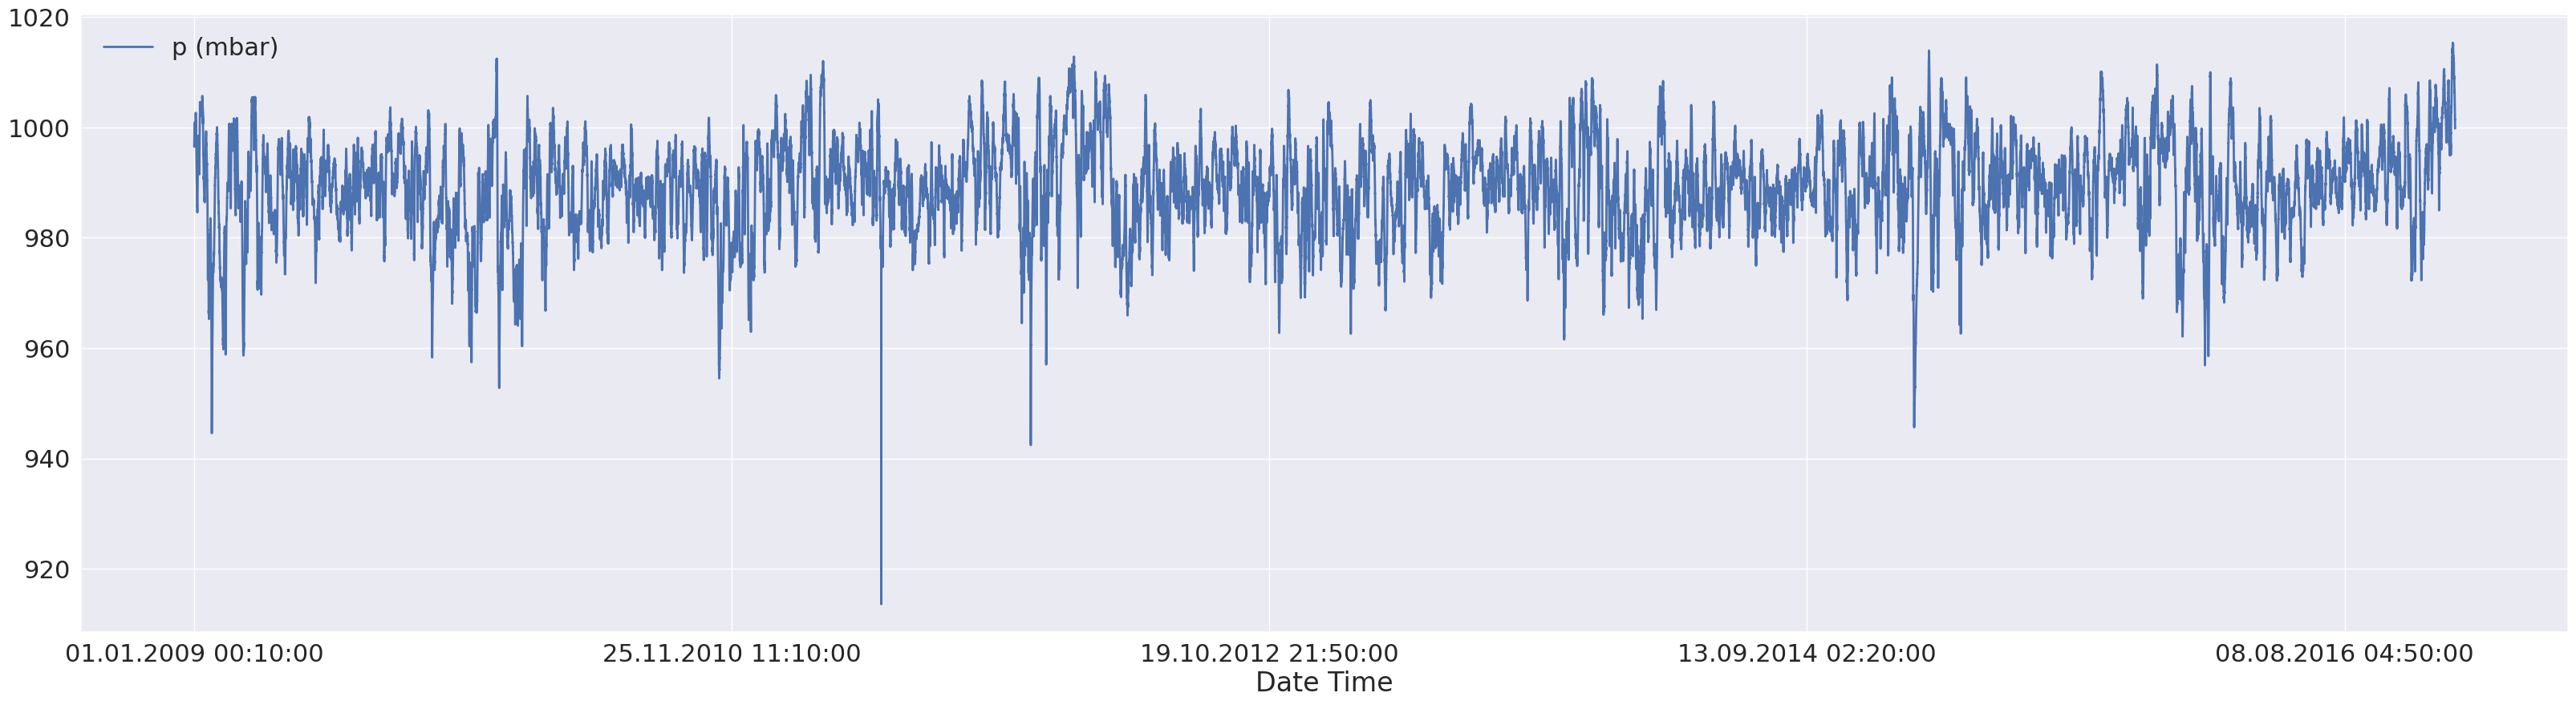

In [7]:
donnees.plot.line(x='Date Time',y='p (mbar)',figsize=(40,10),lw=2);

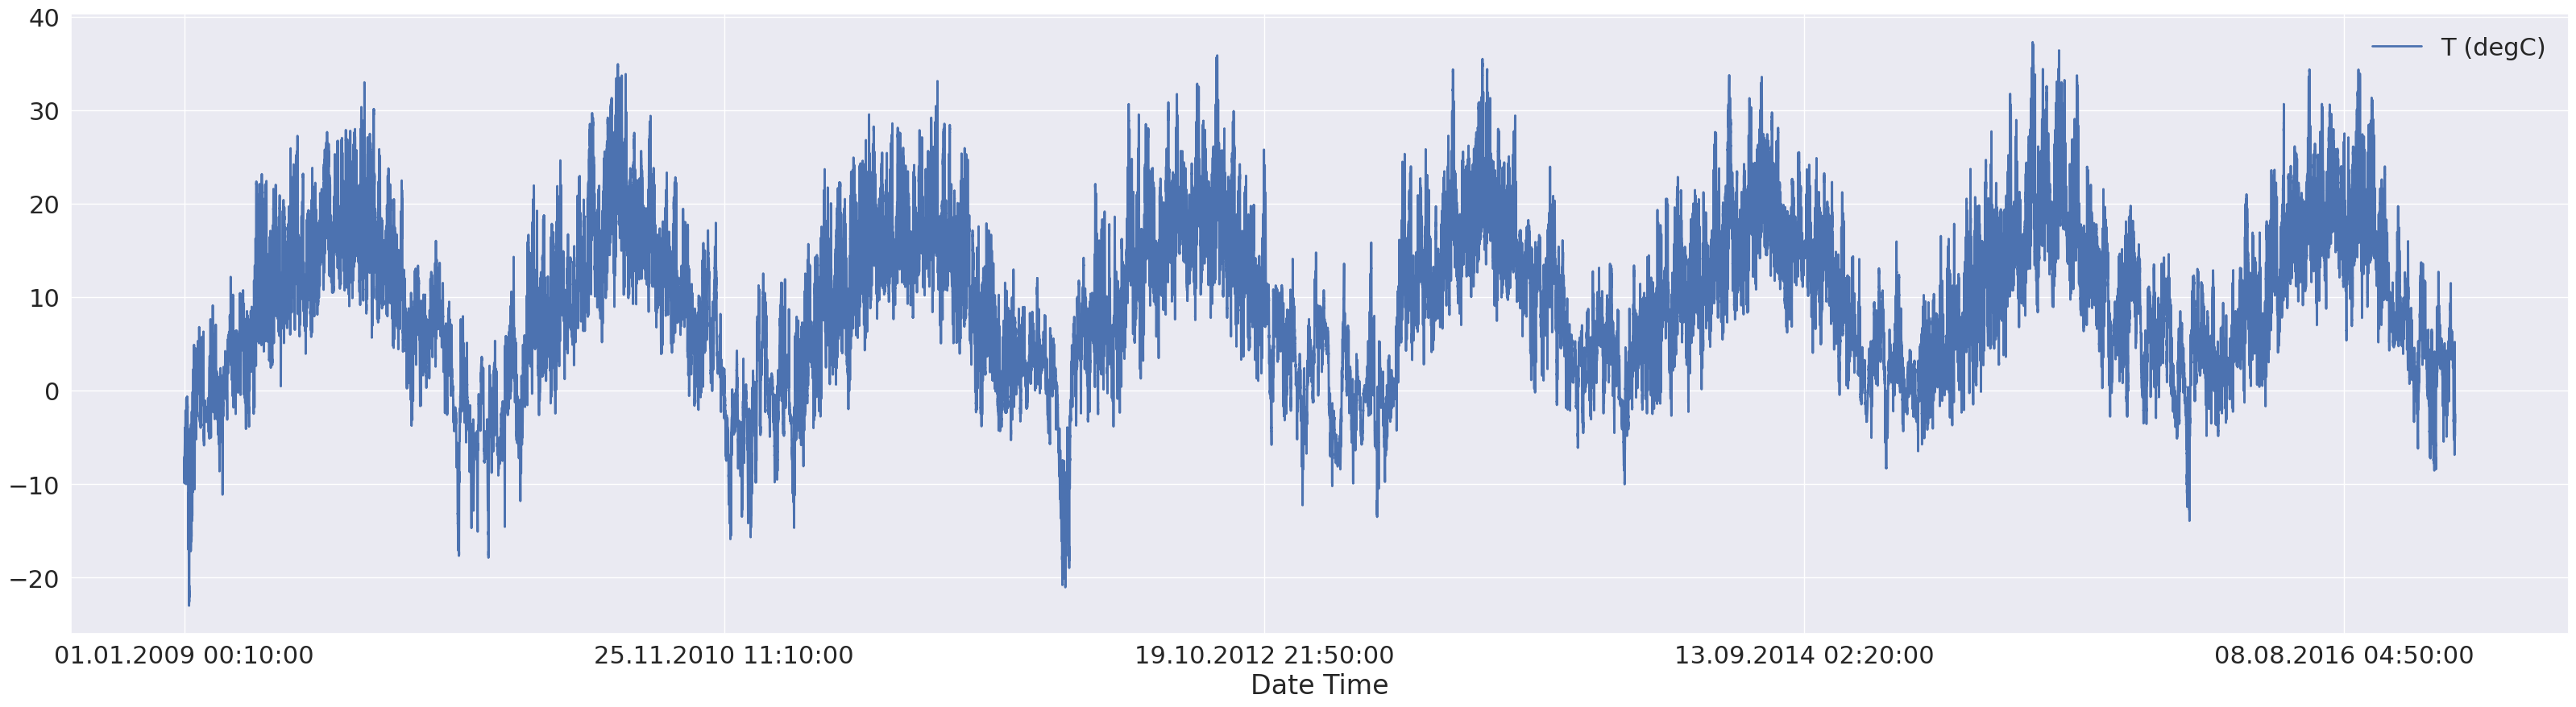

In [8]:
donnees.plot.line(x='Date Time',y='T (degC)',figsize=(40,10),lw=2);

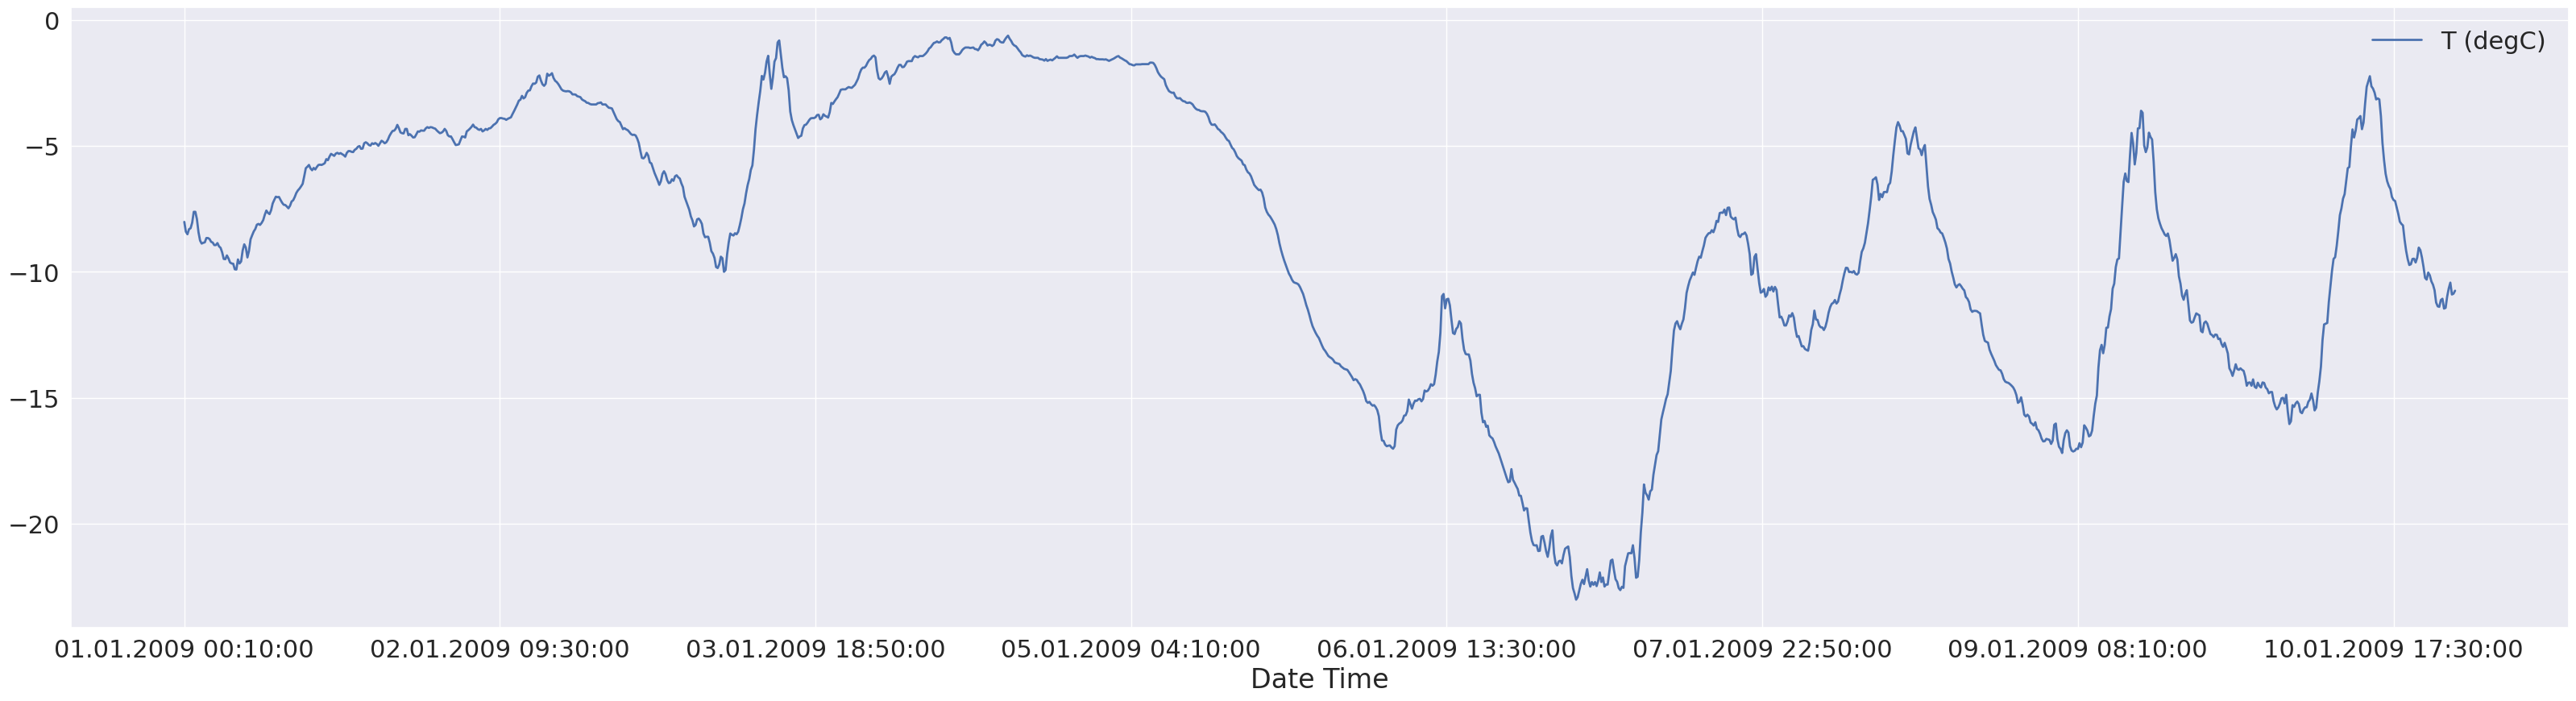

In [9]:
donnees.iloc[:1440,:].plot.line(x='Date Time',y='T (degC)',figsize=(40,10),lw=2);

In [10]:
donnees.set_index('Date Time',inplace=True)
donnees.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00          3.33          3.11          0.22       1.94   
01.01.2009 00:20:00          3.23          3.02          0.21       1.89   
01.01.2009 00:30:00          3.21          3.01          0.20       1.88   
01.01.2009 00:40:00          3.26          3.07          0.19       1.92   
01.01.2009 00:50:00          3.27          3.08          0.19       1.92   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
01.01.2009 00:10:00             3.12       1307.75      1.03           1.75   
01.01.2009 00:20:00             3.03       1309.80      0.72           1.50   
01.01.2009 00:30:00             3.02       1310.24      0.19           0.63   
01.01.2009 00:40:00             3.08       1309.19      0.34           0.50   
01.01.2009 00:50:00             3.09       1309.00      0.32           0.63   

                     wd (deg)  
Date Time                      
01.01.2009 00:10:00     152.3  
01.01.2009 00:20:00     136.1  
01.01.2009 00:30:00     171.6  
01.01.2009 00:40:00     198.0  
01.01.2009 00:50:00     214.3

In [11]:
from sklearn.preprocessing import StandardScaler

modelSS = StandardScaler()
modelSS.fit(donnees.iloc[:200000,:])

donneesSS = pd.DataFrame(modelSS.transform(donnees),columns=donnees.columns,index=donnees.index)

In [12]:
donneesSS.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
Date Time                                                                  
01.01.2009 00:10:00  0.900147 -1.931358 -1.982110    -1.862800  1.072852   
01.01.2009 00:20:00  0.906043 -1.975414 -2.025670    -1.915830  1.078831   
01.01.2009 00:30:00  0.901327 -1.986710 -2.036839    -1.920016  1.108722   
01.01.2009 00:40:00  0.898968 -1.964118 -2.013384    -1.886524  1.126657   
01.01.2009 00:50:00  0.898968 -1.959599 -2.010033    -1.882337  1.120678   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00     -1.307422     -1.473758     -0.798686  -1.476267   
01.01.2009 00:20:00     -1.320427     -1.495196     -0.800752  -1.495025   
01.01.2009 00:30:00     -1.323028     -1.497578     -0.802818  -1.498776   
01.01.2009 00:40:00     -1.316525     -1.483286     -0.804884  -1.483770   
01.01.2009 00:50:00     -1.315225     -1.480904     -0.804884  -1.483770   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
01.01.2009 00:10:00        -1.478155      2.123751 -0.729505      -0.780680   
01.01.2009 00:20:00        -1.499321      2.171999 -0.931240      -0.887945   
01.01.2009 00:30:00        -1.501673      2.182354 -1.276143      -1.261228   
01.01.2009 00:40:00        -1.487562      2.157642 -1.178529      -1.317006   
01.01.2009 00:50:00        -1.485211      2.153170 -1.191544      -1.261228   

                     wd (deg)  
Date Time                      
01.01.2009 00:10:00 -0.276136  
01.01.2009 00:20:00 -0.463174  
01.01.2009 00:30:00 -0.053306  
01.01.2009 00:40:00  0.251497  
01.01.2009 00:50:00  0.439690

In [44]:
from sklearn.metrics import mean_absolute_error,median_absolute_error,mean_squared_error,mean_squared_log_error,r2_score

def affichageMetricsSansLog(val_reels, val_predites):
    print("Mean absolute error                 MAE   : %.6f" % mean_absolute_error(val_reels, val_predites))
    print("Median absolute error               MedAE : %.6f" % median_absolute_error(val_reels, val_predites))
    print("Mean squared error                  MSE   : %.6f" % mean_squared_error(val_reels, val_predites))
    #print("Mean squared logarithmic error      MSLE  : %.6f" % mean_squared_log_error(val_reels, val_predites))
    print("Root mean squared error             RMSE  : %.6f" % np.sqrt(mean_squared_error(val_reels, val_predites)))
    #print("Root mean squared logarithmic error RMSLE : %.6f" % np.sqrt(mean_squared_log_error(val_reels, val_predites)))
    print("R² score  raw_values                R²    : %.6f" % r2_score(val_reels, val_predites, multioutput='raw_values'))
    print("R² score  uniform_average           R²    : %.6f" % r2_score(val_reels, val_predites, multioutput='uniform_average'))
    print("R² score  variance_weighted         R²    : %.6f" % r2_score(val_reels, val_predites, multioutput='variance_weighted'))
    print("R  score  raw_values                R     : %.6f" % np.sqrt(abs(r2_score(val_reels, val_predites, multioutput='raw_values'))))
    print("R  score  uniform_average           R     : %.6f" % np.sqrt(abs(r2_score(val_reels, val_predites, multioutput='uniform_average'))))
    print("R  score  variance_weighted         R     : %.6f" % np.sqrt(abs(r2_score(val_reels, val_predites, multioutput='variance_weighted'))))
    correlations = pd.DataFrame(list(zip(val_predites,val_reels)), columns=['predictions','valeurs'])
    sns.set(font_scale=3)
    plt.figure(figsize=(26,26))
    plt.title('Correlation Pearson des variables', y=1.05, size=38)
    sns.heatmap(correlations.astype(float).corr(),linewidths=0.3,vmax=1.0,fmt ="1.9f", 
                square=True, cmap='coolwarm', linecolor='white', annot=True)
    plt.show()    
    plt.figure(figsize=(26,26))
    plt.scatter(correlations.valeurs,correlations.predictions, alpha=0.4, s=200, c='black', edgecolors='white')
    plt.scatter(correlations.valeurs,correlations.predictions, alpha=0.3, 
                s=200+abs(correlations.valeurs - correlations.predictions)*100, c='red', edgecolors='black')
    plt.plot((correlations.valeurs.min(), correlations.valeurs.max()), 
             (correlations.valeurs.min(), correlations.valeurs.max()), c='black', ls="--", alpha=0.6) 
    plt.xlabel('valeurs')
    plt.ylabel('predictions')
    plt.show()   
    
    sns.jointplot(x='valeurs',y='predictions',data=correlations, kind='reg', height=25)

In [14]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [15]:
1440/60

24.0

In [16]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(donneesSS.values,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(donneesSS.values,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(donneesSS.values,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(donneesSS.values) - 300001 - lookback) // batch_size

In [17]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28973597299054815


In [18]:
donneesSS.shape[-1]

14

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, donneesSS.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=24,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/24
 58/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5080

I0000 00:00:1752071656.179728 3289068 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9416 - val_loss: 0.7265
Epoch 2/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5731 - val_loss: 0.3779
Epoch 3/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3158 - val_loss: 0.3126
Epoch 4/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2801 - val_loss: 0.3087
Epoch 5/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2589 - val_loss: 0.3022
Epoch 6/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2491 - val_loss: 0.3518
Epoch 7/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2400 - val_loss: 0.3550
Epoch 8/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2322 - val_loss: 0.3244
Epoch 9/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2278 - val_loss: 0.3165
Epoch 10/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2216 - val_loss: 0.3238
Epoch 11/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2186 - val_loss: 0.3754
Epoch 12/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.

In [20]:
history.history

{'loss': [1.3044039011001587,
  0.47953760623931885,
  0.3014242649078369,
  0.27349987626075745,
  0.2568991184234619,
  0.24648511409759521,
  0.2385106086730957,
  0.2310550957918167,
  0.22653599083423615,
  0.22095641493797302,
  0.21734227240085602,
  0.21399803459644318,
  0.2122308313846588,
  0.20942044258117676,
  0.20638695359230042,
  0.20352239906787872,
  0.20350073277950287,
  0.1996818482875824,
  0.1978083848953247,
  0.19718533754348755,
  0.19461296498775482,
  0.19261875748634338,
  0.19361741840839386,
  0.19130904972553253],
 'val_loss': [0.7265251278877258,
  0.37786683440208435,
  0.3126470446586609,
  0.30868491530418396,
  0.3022351861000061,
  0.3518088161945343,
  0.35496634244918823,
  0.3244387209415436,
  0.316545695066452,
  0.3238062262535095,
  0.3754052519798279,
  0.3628399968147278,
  0.3218473792076111,
  0.32080578804016113,
  0.3406731188297272,
  0.3225939869880676,
  0.340320885181427,
  0.3322256803512573,
  0.32716497778892517,
  0.3541645109

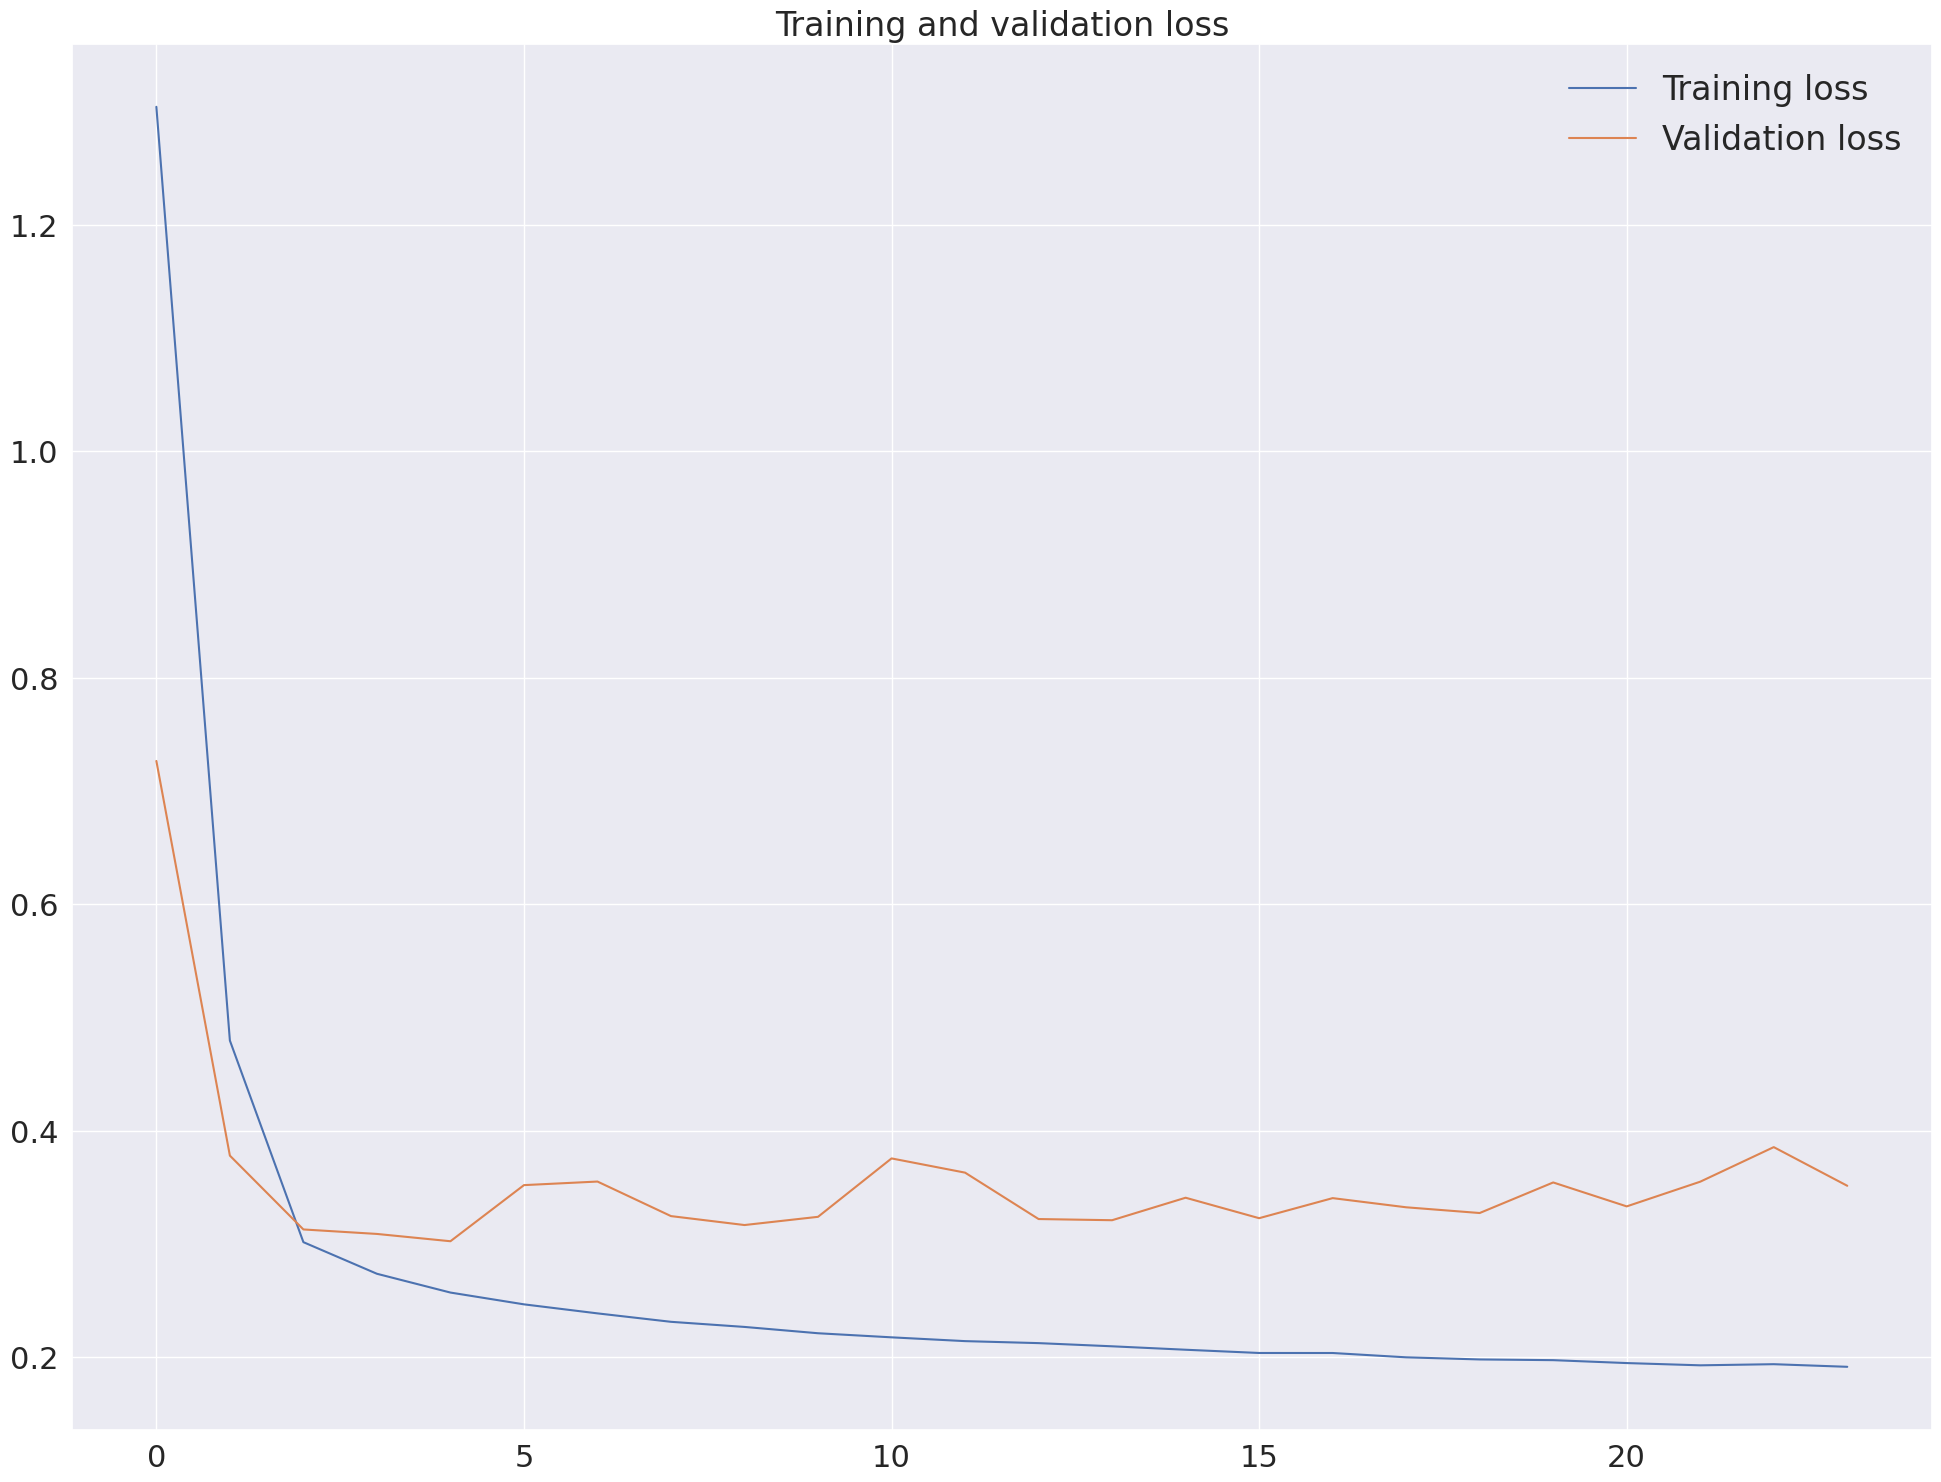

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

# Long Short-Term Memory

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, donneesSS.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit( train_gen,
                     steps_per_epoch=500,
                     epochs=24,
                     validation_data=val_gen,
                     validation_steps=val_steps)

Epoch 1/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.3319 - val_loss: 0.2688
Epoch 2/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2781 - val_loss: 0.2678
Epoch 3/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2684 - val_loss: 0.2699
Epoch 4/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2568 - val_loss: 0.2703
Epoch 5/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2505 - val_loss: 0.2775
Epoch 6/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2395 - val_loss: 0.2908
Epoch 7/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2351 - val_loss: 0.2918
Epoch 8/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2250 - val_loss: 0.2950
Epoch 9/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2202 - val_loss: 0.2984
Epoch 10/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2161 - val_loss: 0.3067
Epoch 11/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2113 - val_loss: 0.3054
Epoch 12/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 

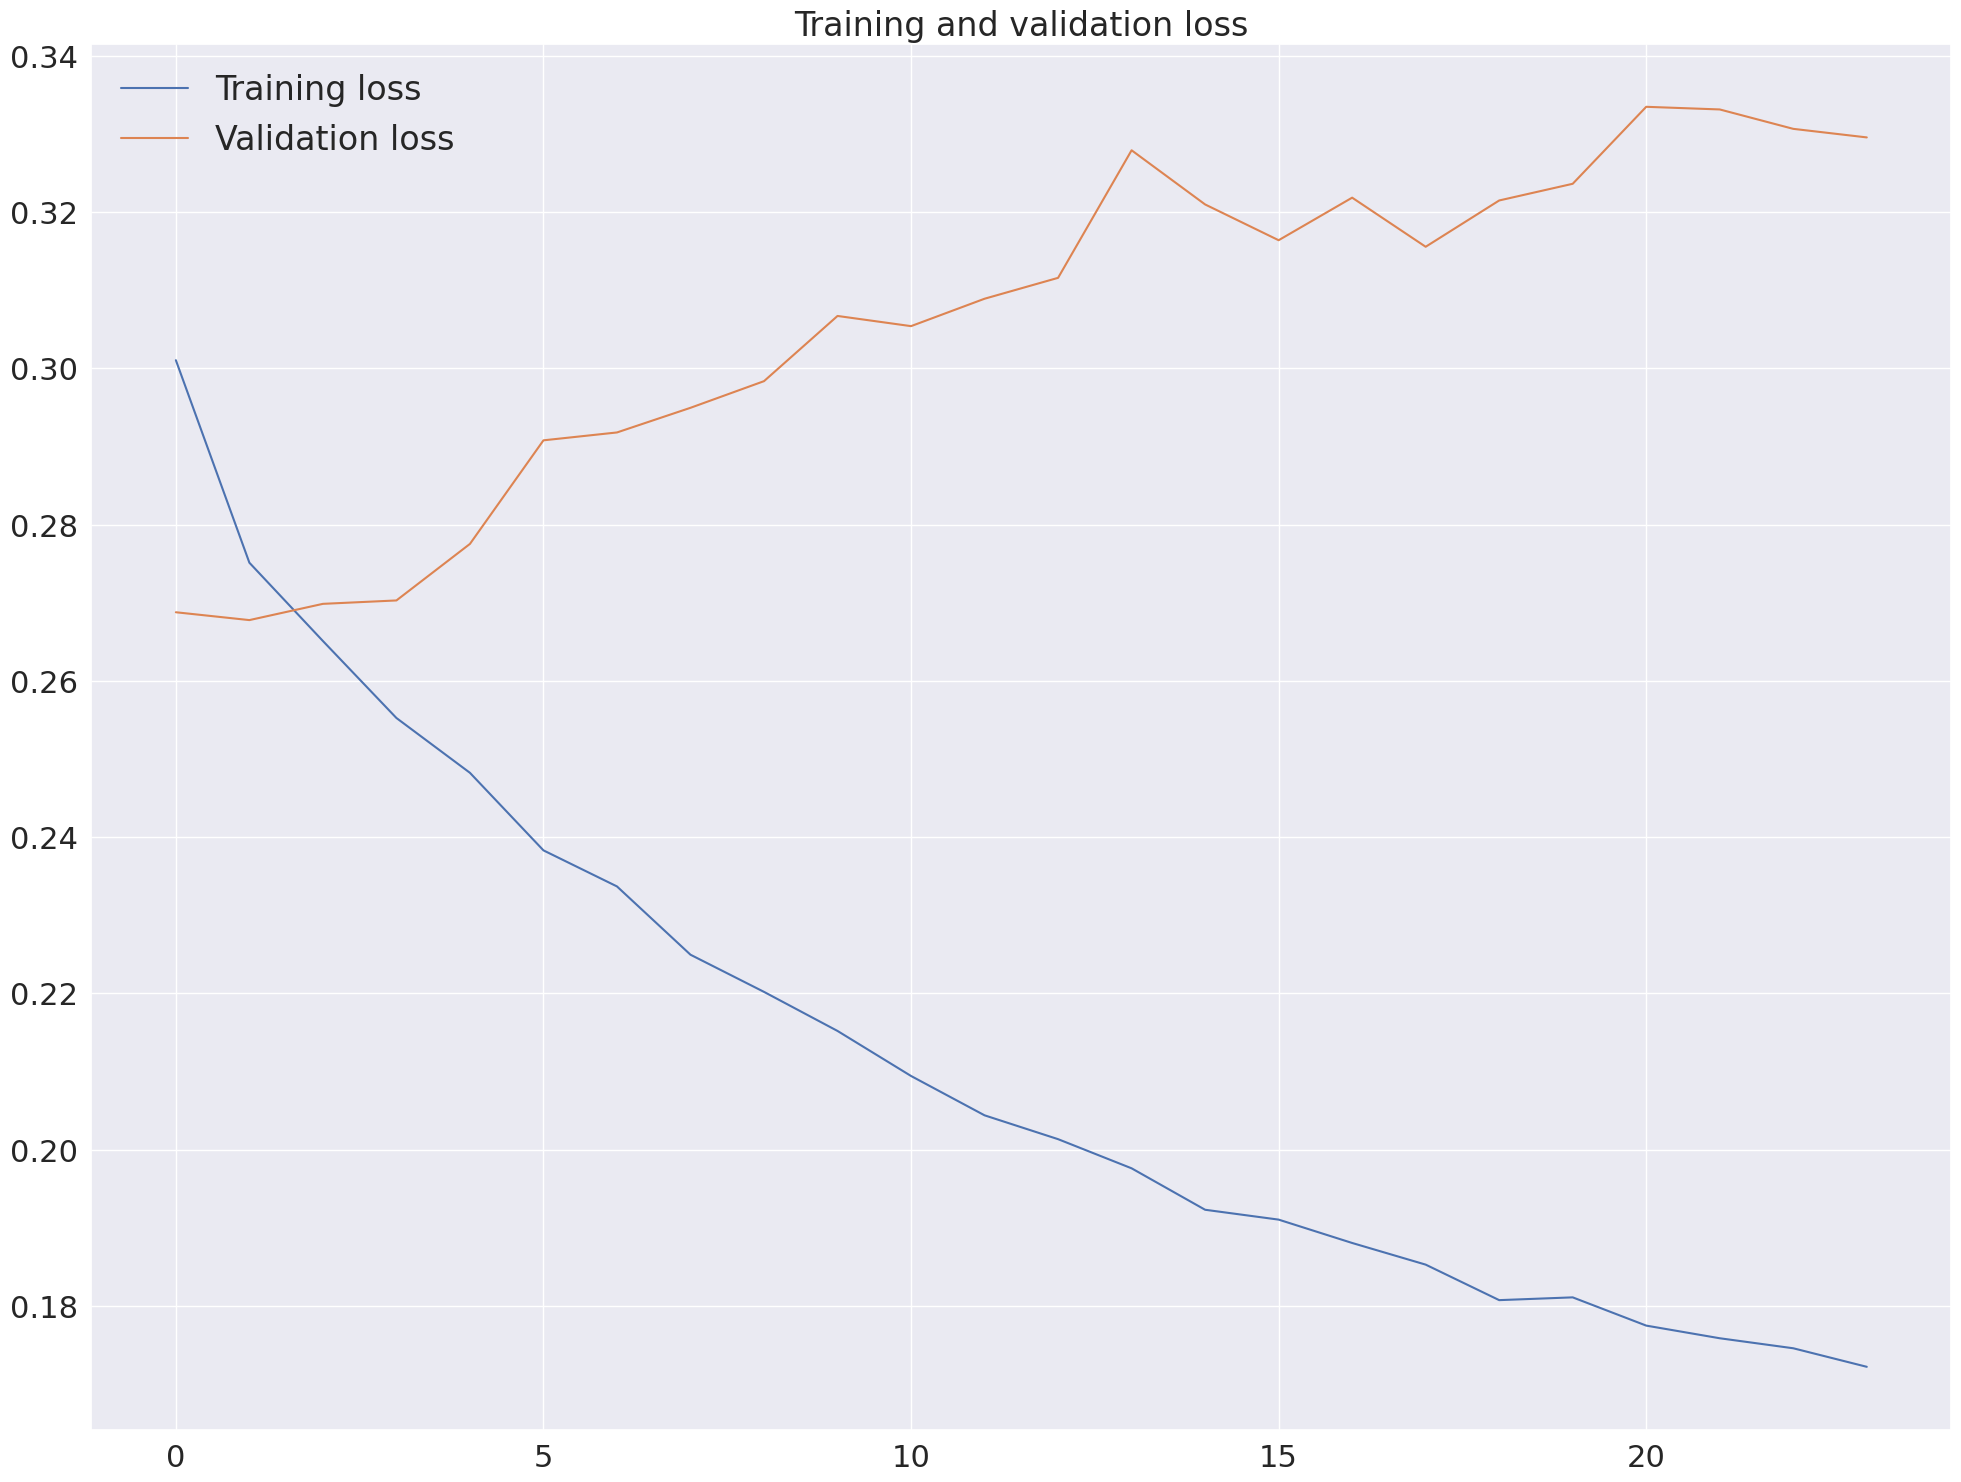

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.optimizers import RMSprop

model = Sequential()
#model.add(layers.LSTM(32, return_sequences=True, input_shape=(None, donneesSS.shape[-1])))
#model.add(layers.LSTM(32, return_sequences=True))
#model.add(layers.LSTM(32))
#model.add(layers.Dense(1))

model.add(LSTM(256, return_sequences=True, input_shape=(None, donneesSS.shape[-1])))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))



model.compile(optimizer='adam', loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=24,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.3580 - val_loss: 0.2812
Epoch 2/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2985 - val_loss: 0.2802
Epoch 3/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.2887 - val_loss: 0.2711
Epoch 4/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.2830 - val_loss: 0.2895
Epoch 5/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2536 - val_loss: 0.2907
Epoch 6/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2302 - val_loss: 0.3003
Epoch 7/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2049 - val_loss: 0.3120
Epoch 8/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.1860 - val_loss: 0.3035
Epoch 9/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.1677 - val_loss: 0.3185
Epoch 10/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.1537 - val_loss: 0.3192
Epoch 11/24
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.1415 - val_loss: 0.3220
Epoch 12/24
500/500 ━━━━━━━━━━

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, None, 256)      │       277,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,985,157 (15.20 MB)

 Trainable params: 1,328,385 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,656,772 (10.13 MB)

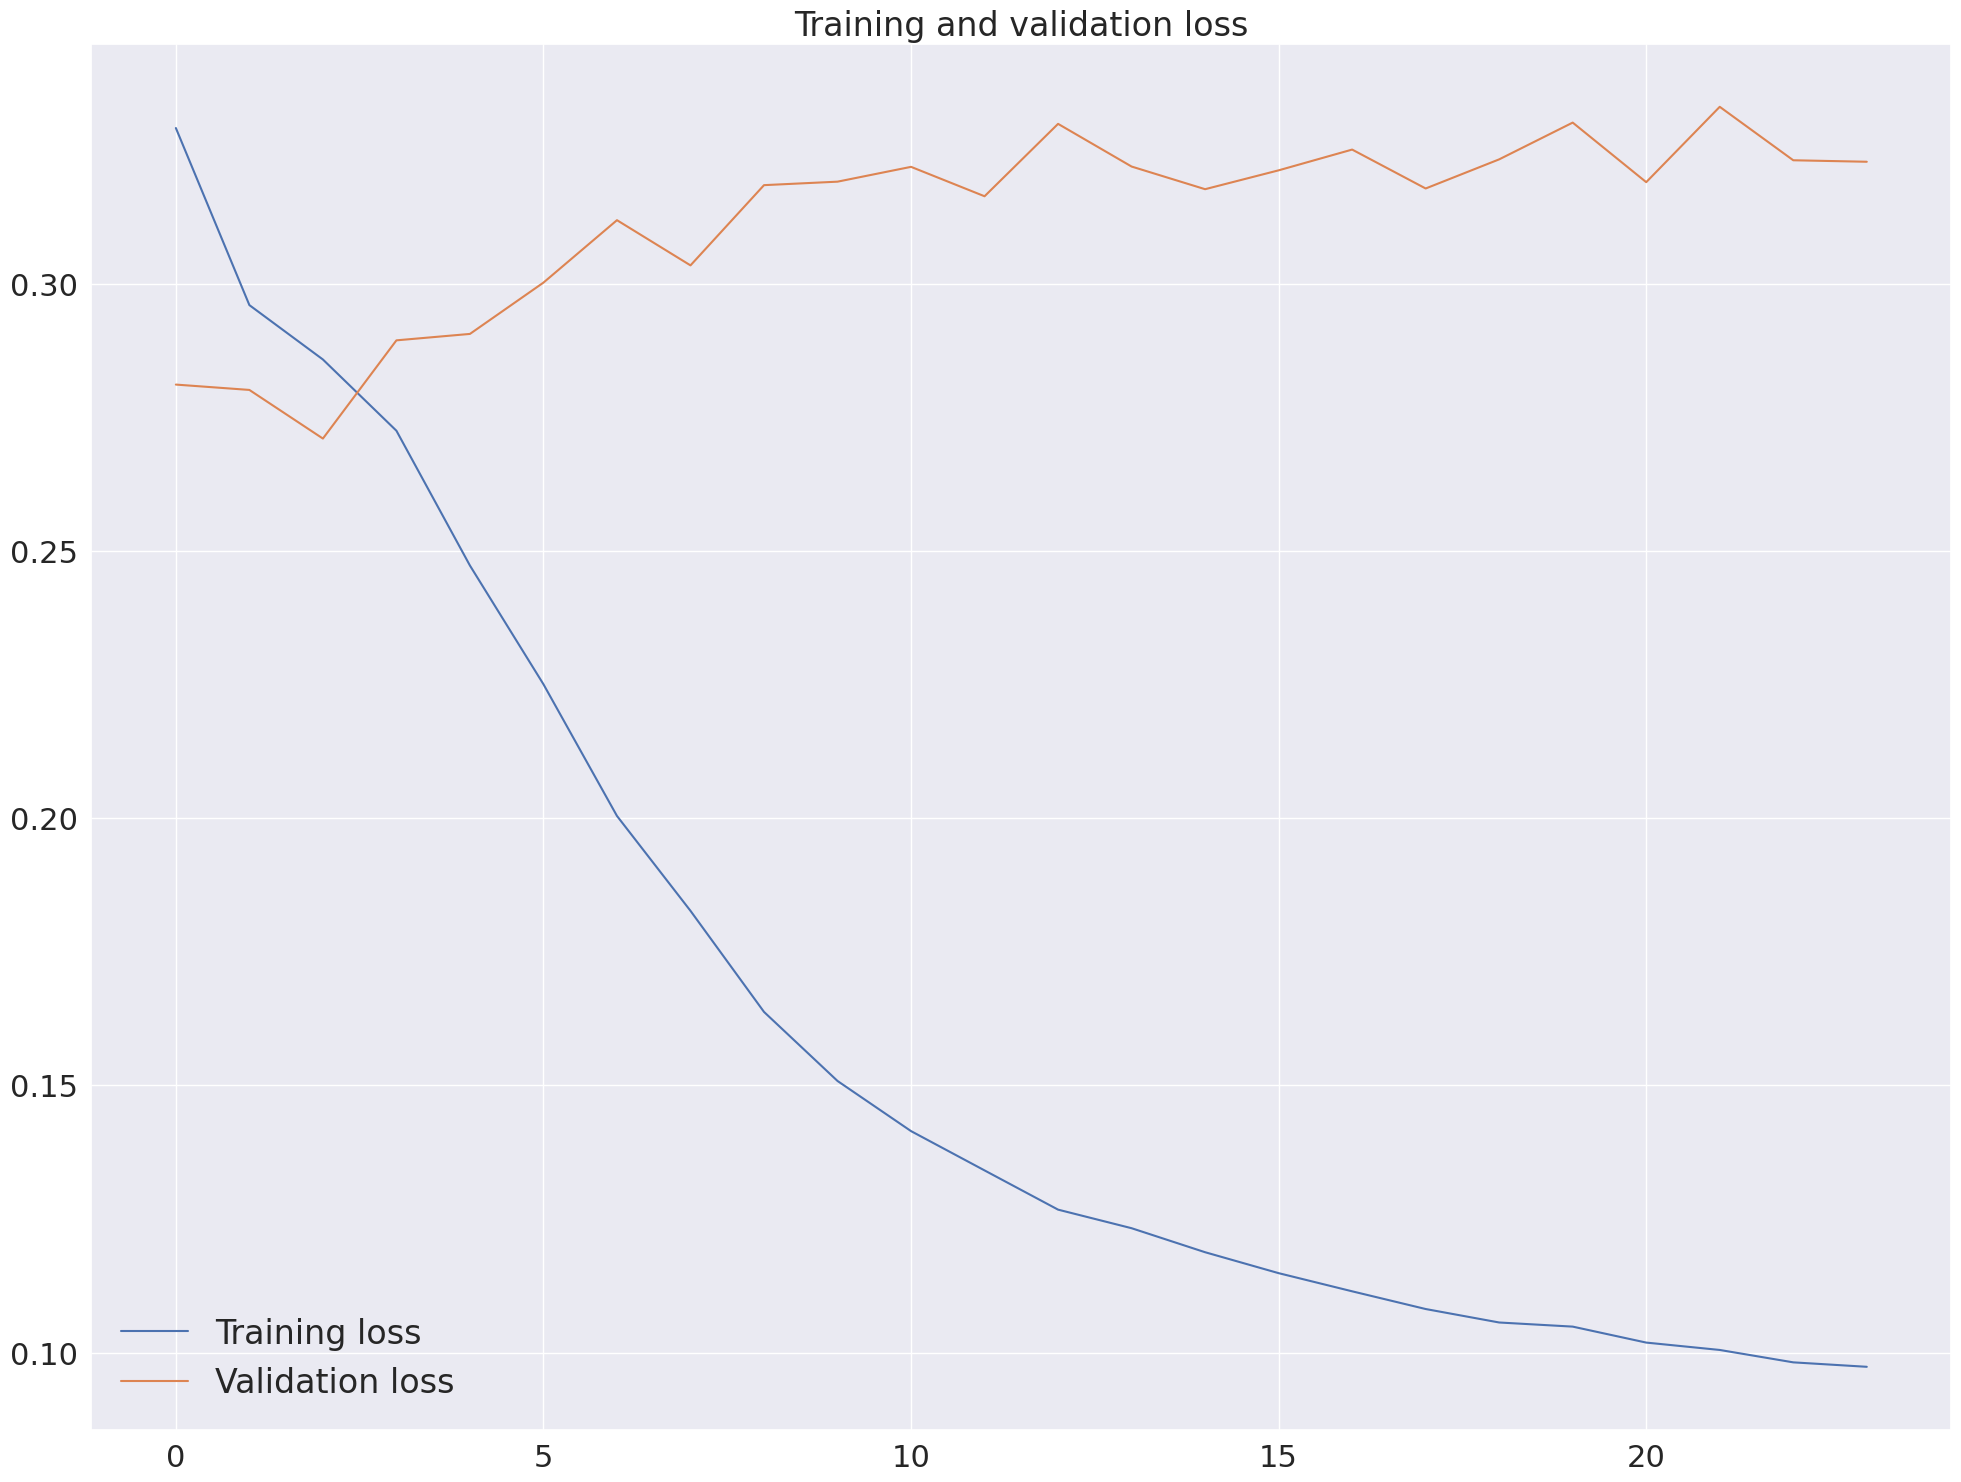

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

# Gated Recurrent Unit

In [27]:
from keras.layers import GRU
from keras.layers import Dense

model = Sequential()
model.add(GRU(32,input_shape=(None,donnees.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=48,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3853 - val_loss: 0.2749
Epoch 2/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2898 - val_loss: 0.2681
Epoch 3/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2865 - val_loss: 0.2631
Epoch 4/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2780 - val_loss: 0.2696
Epoch 5/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2737 - val_loss: 0.2626
Epoch 6/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2684 - val_loss: 0.2636
Epoch 7/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2625 - val_loss: 0.2654
Epoch 8/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2602 - val_loss: 0.2661
Epoch 9/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2541 - val_loss: 0.2690
Epoch 10/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2521 - val_loss: 0.2738
Epoch 11/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2455 - val_loss: 0.2700
Epoch 12/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 

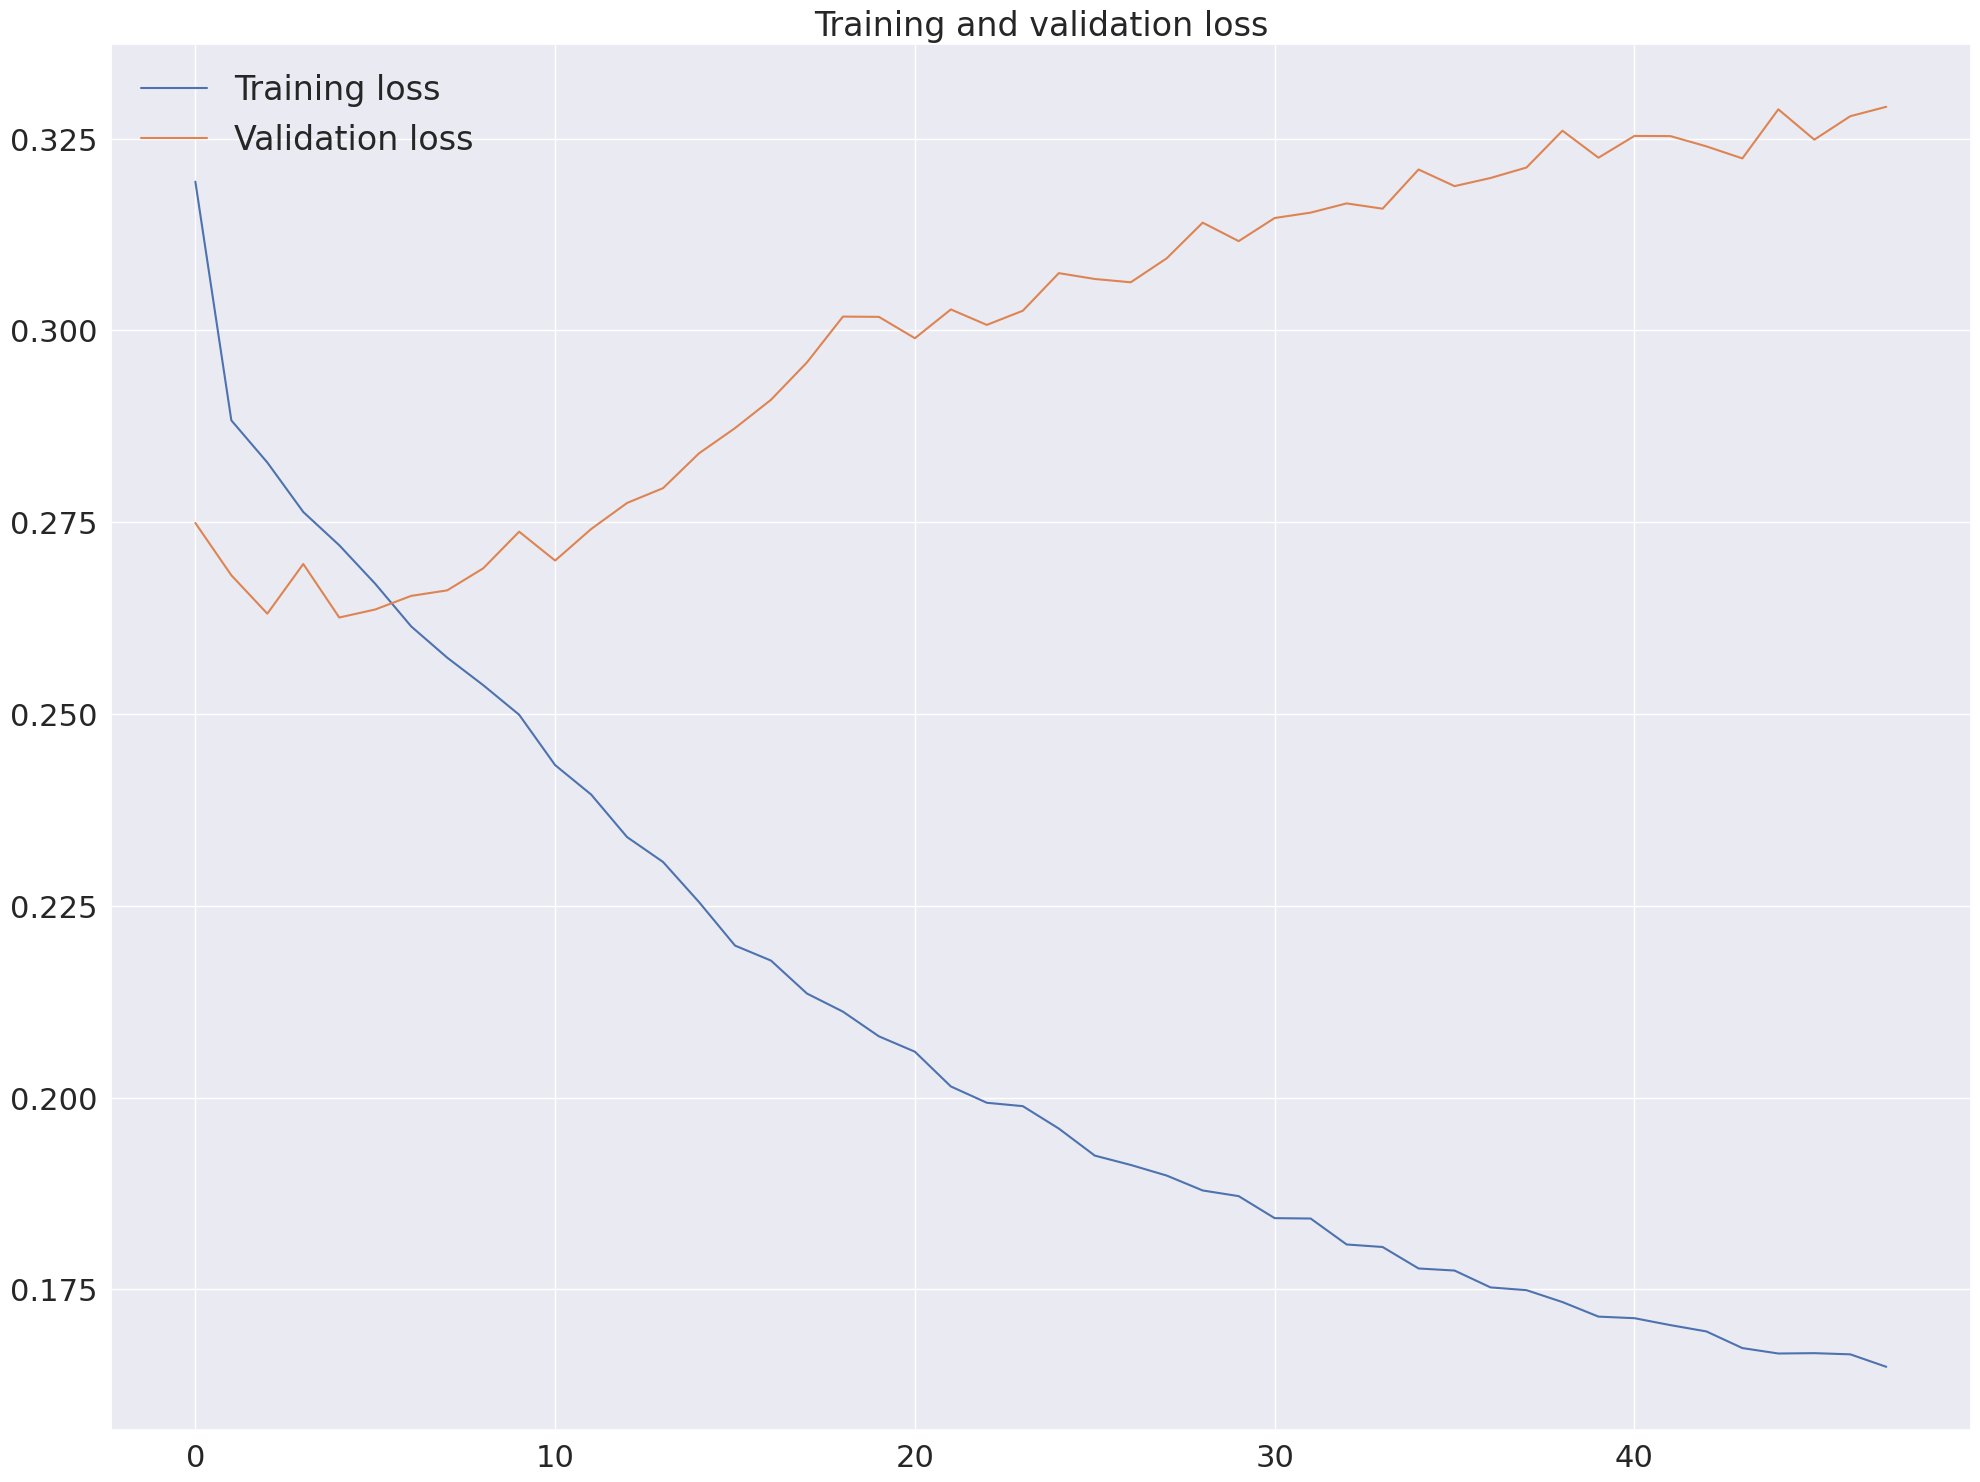

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [29]:
from keras.layers import GRU,Bidirectional
from keras.layers import Dense

model = Sequential()
model.add(Bidirectional(GRU(32),input_shape=(None, donnees.shape[-1])))

model.add(Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=48,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3176 - val_loss: 0.2711
Epoch 2/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2794 - val_loss: 0.2701
Epoch 3/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2720 - val_loss: 0.2648
Epoch 4/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2651 - val_loss: 0.2706
Epoch 5/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2637 - val_loss: 0.2693
Epoch 6/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2572 - val_loss: 0.2656
Epoch 7/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2560 - val_loss: 0.2678
Epoch 8/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2496 - val_loss: 0.2700
Epoch 9/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2463 - val_loss: 0.2727
Epoch 10/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2404 - val_loss: 0.2760
Epoch 11/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2335 - val_loss: 0.2772
Epoch 12/48
500/500 ━━━━━━━━━━━━━━

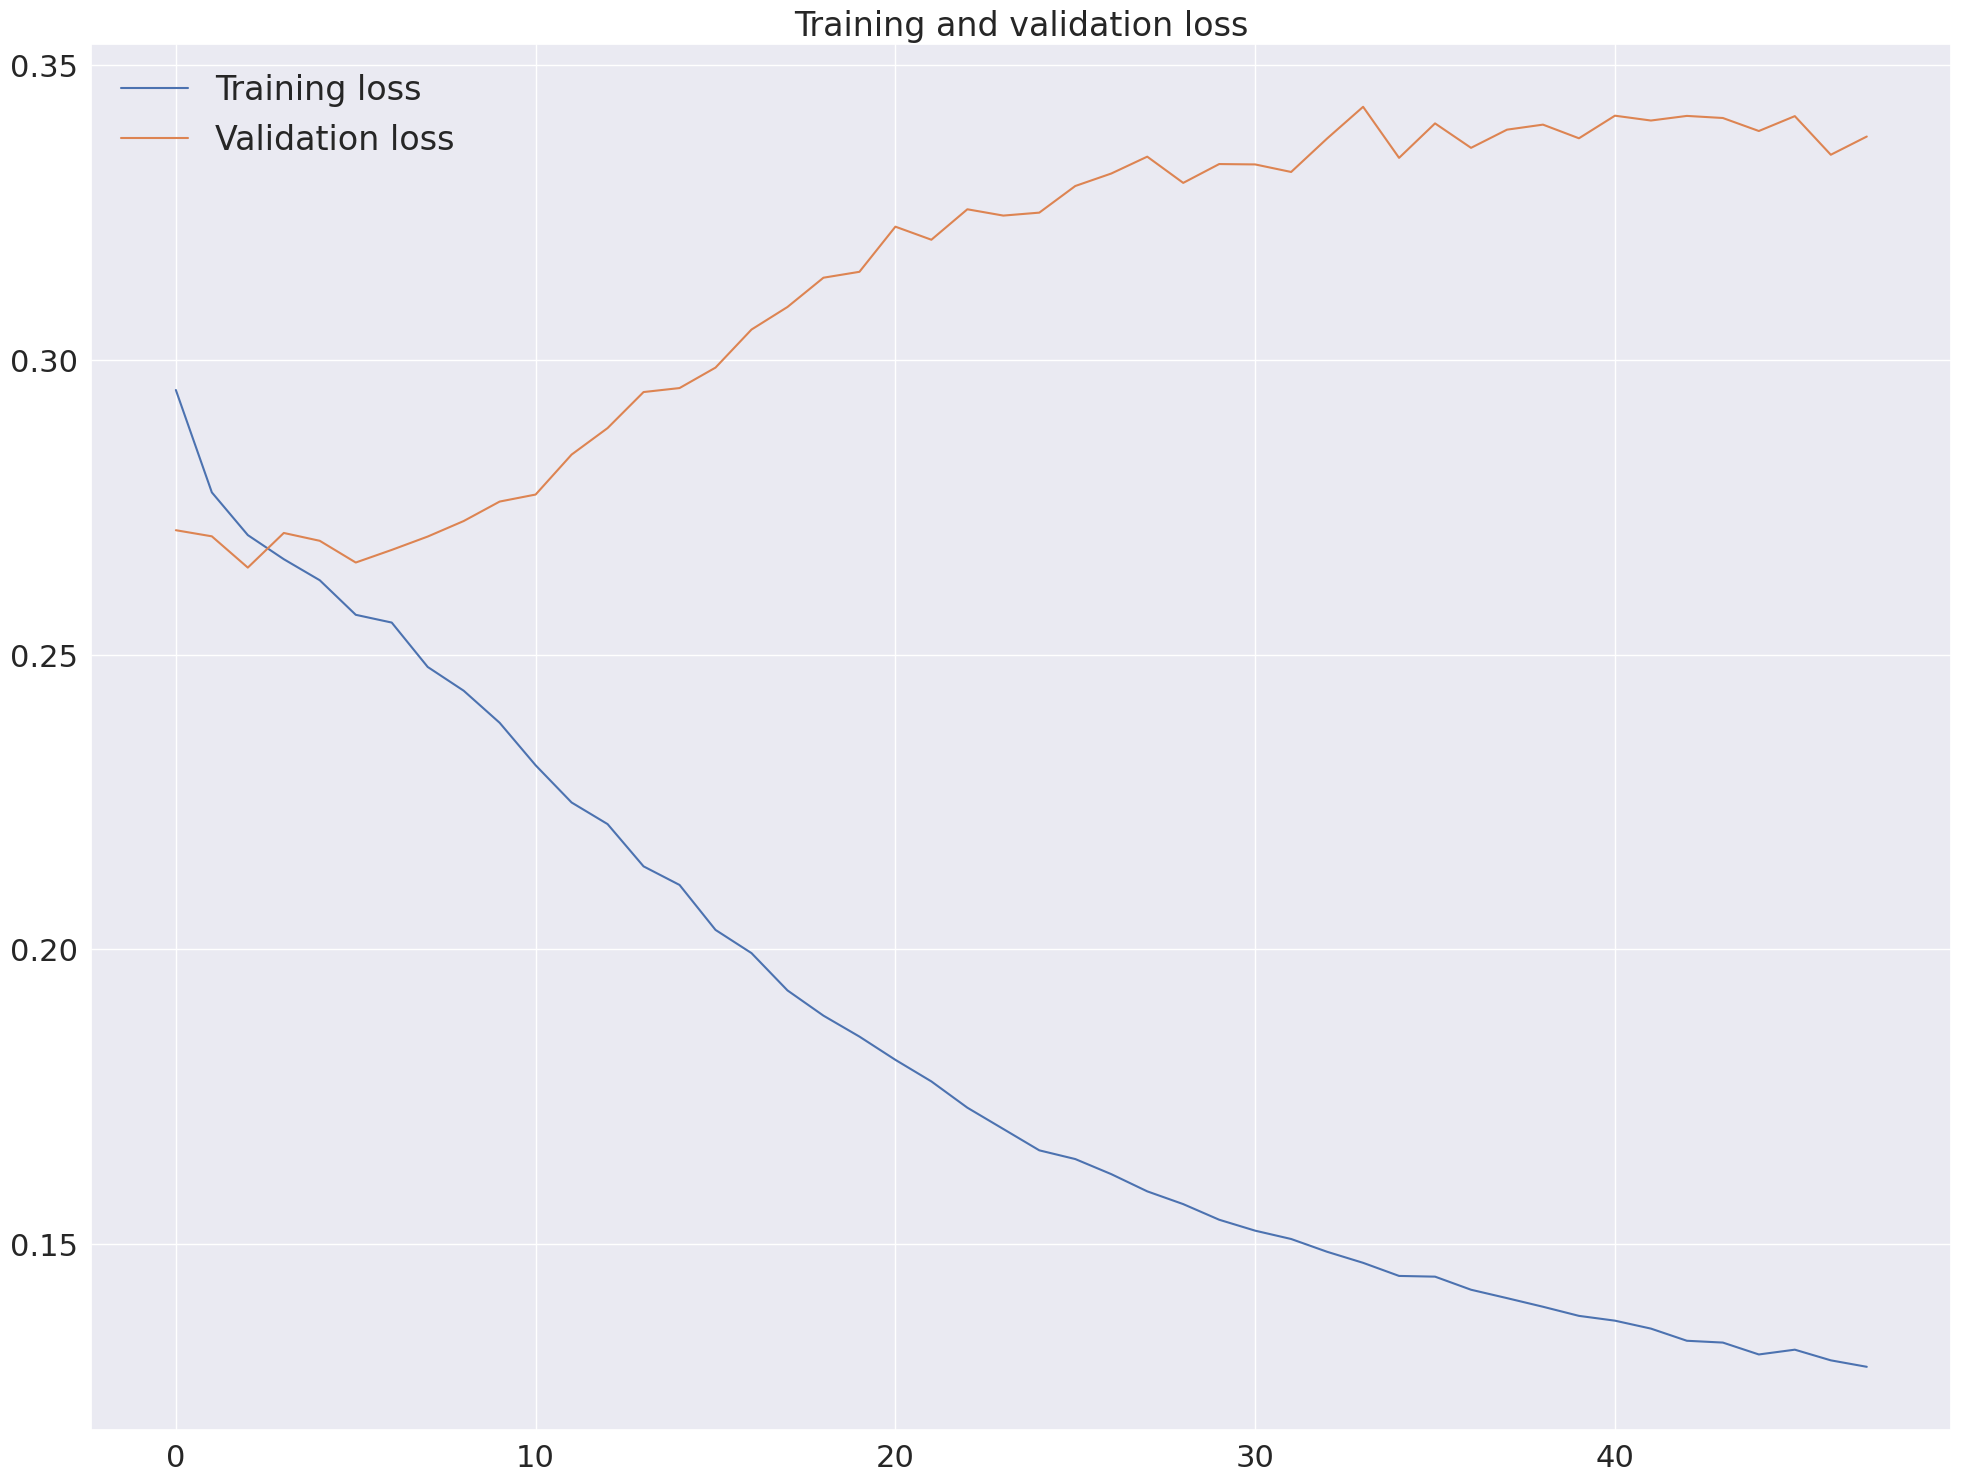

In [30]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, return_sequences=True, input_shape=(None, donneesSS.shape[-1])))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [32]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau,TensorBoard

earlyStopper = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=48,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=[earlyStopper])

Epoch 1/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.3698 - val_loss: 0.3012
Epoch 2/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.2818 - val_loss: 0.2811
Epoch 3/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2610 - val_loss: 0.2962
Epoch 4/48
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2443 - val_loss: 0.2991


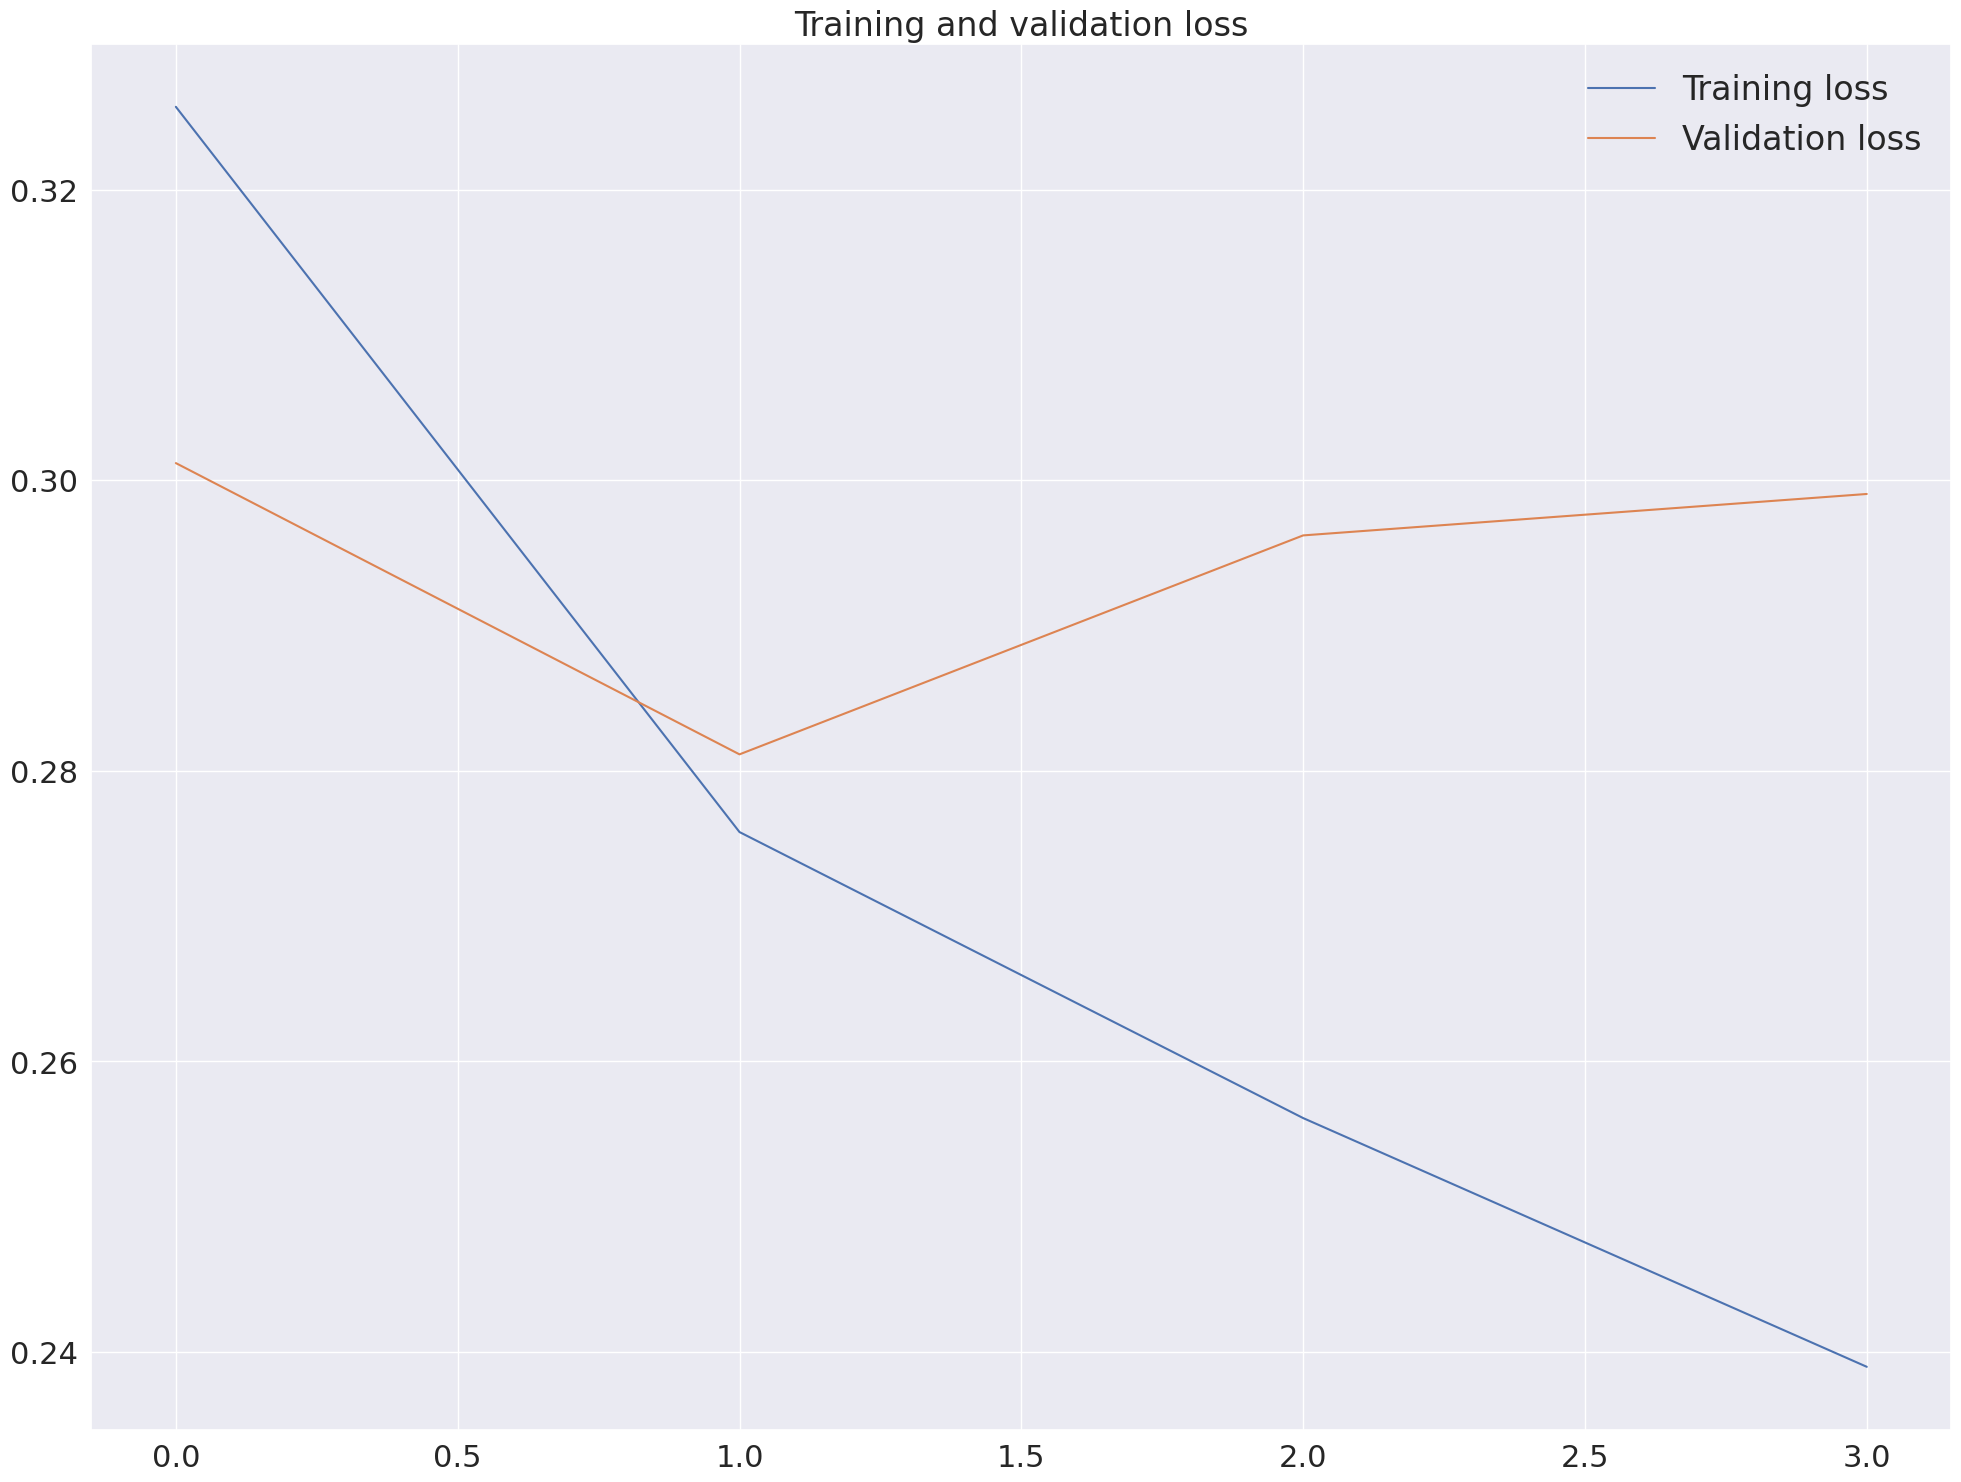

In [33]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [34]:
donneesSS.shape

(420551, 14)

In [36]:
y_pred = model.predict(val_gen,steps=val_steps)

769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [37]:
y_pred.shape

(98432, 1)

In [38]:
_,y_test = next(val_gen)

for step in range(val_steps - 1):
    _, targets = next(val_gen)
    y_test = np.append(y_test,targets)


In [39]:
y_test.shape

(98432,)

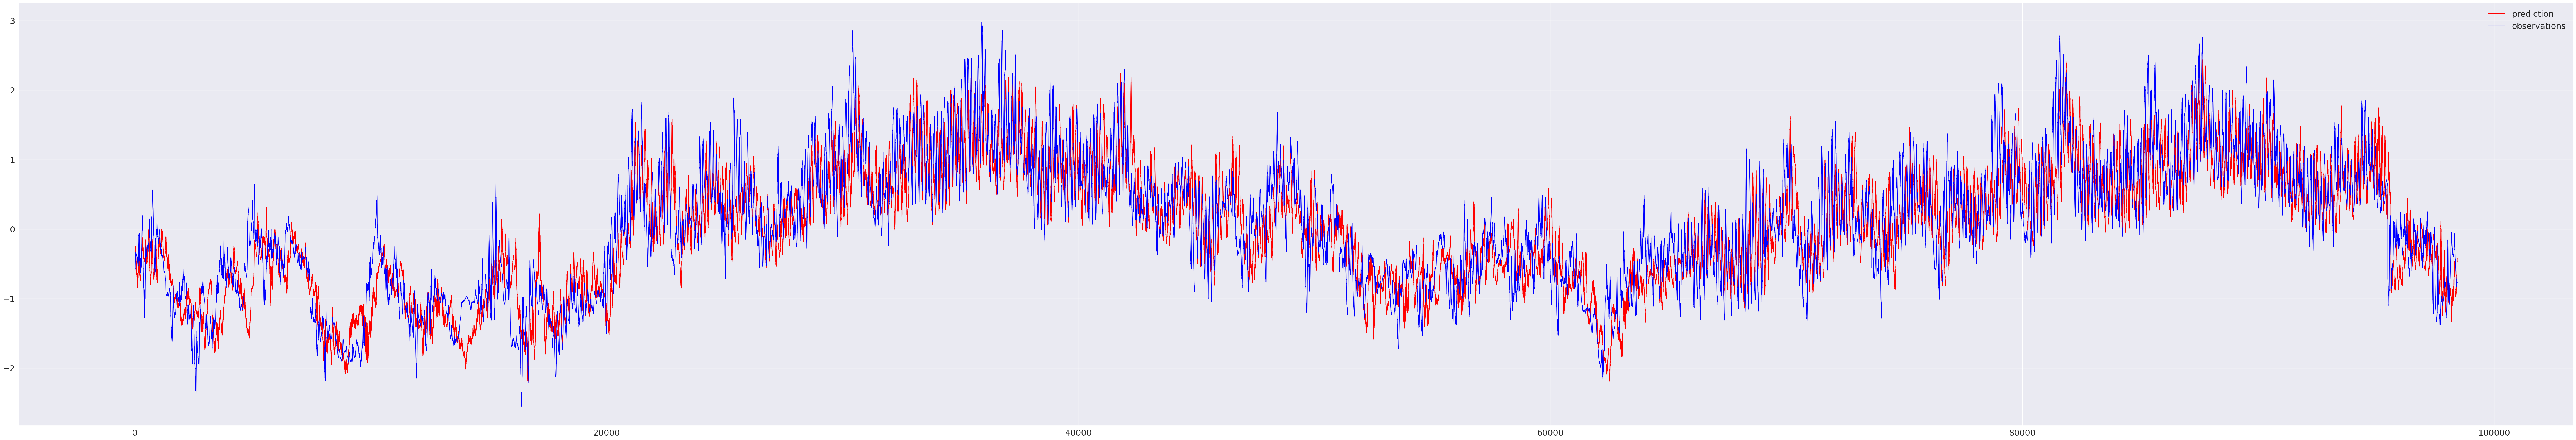

In [40]:
plt.figure(figsize=(120,20))
plt.plot(range(len(y_pred)), y_pred, color='red', label='prediction')
plt.plot(range(len(y_test)), y_test, color='blue', label='observations')
plt.legend()
plt.show()

Mean absolute error                 MAE   : 0.386917
Median absolute error               MedAE : 0.320586
Mean squared error                  MSE   : 0.240318
Root mean squared error             RMSE  : 0.490222
R² score  raw_values                R²    : 0.720042
R² score  uniform_average           R²    : 0.720042
R² score  variance_weighted         R²    : 0.720042
R  score  raw_values                R     : 0.848553
R  score  uniform_average           R     : 0.848553
R  score  variance_weighted         R     : 0.848553


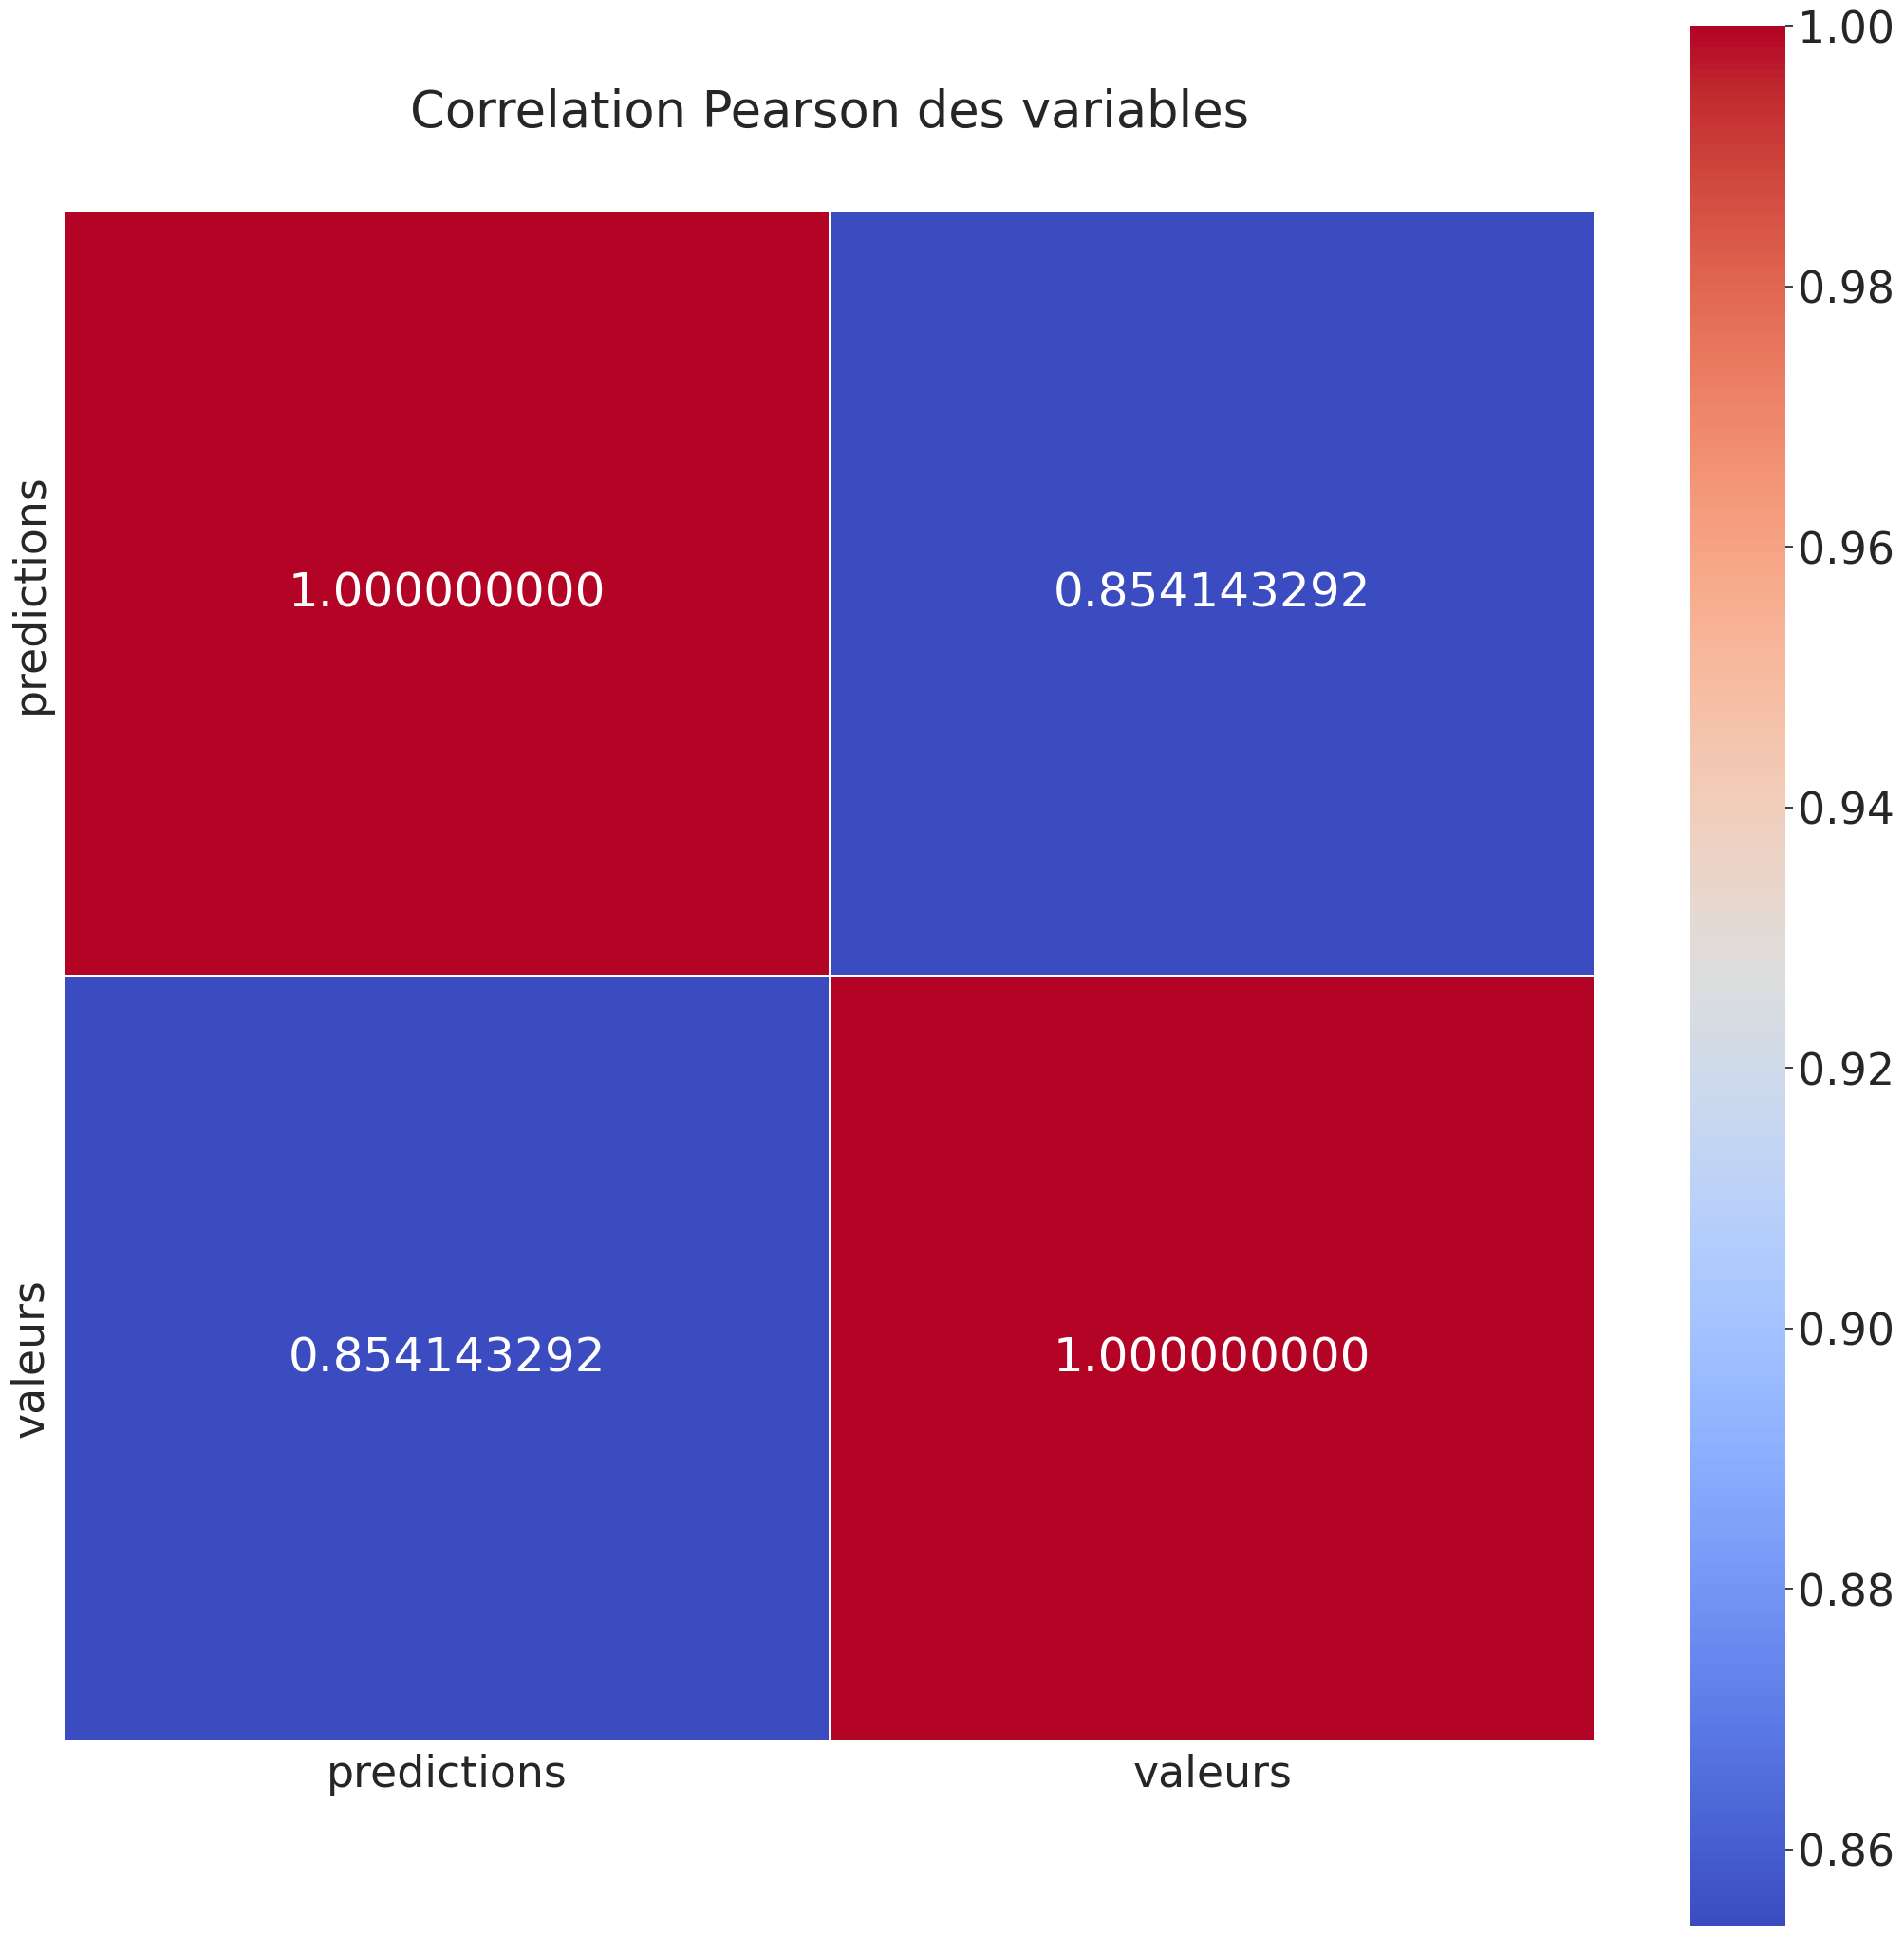

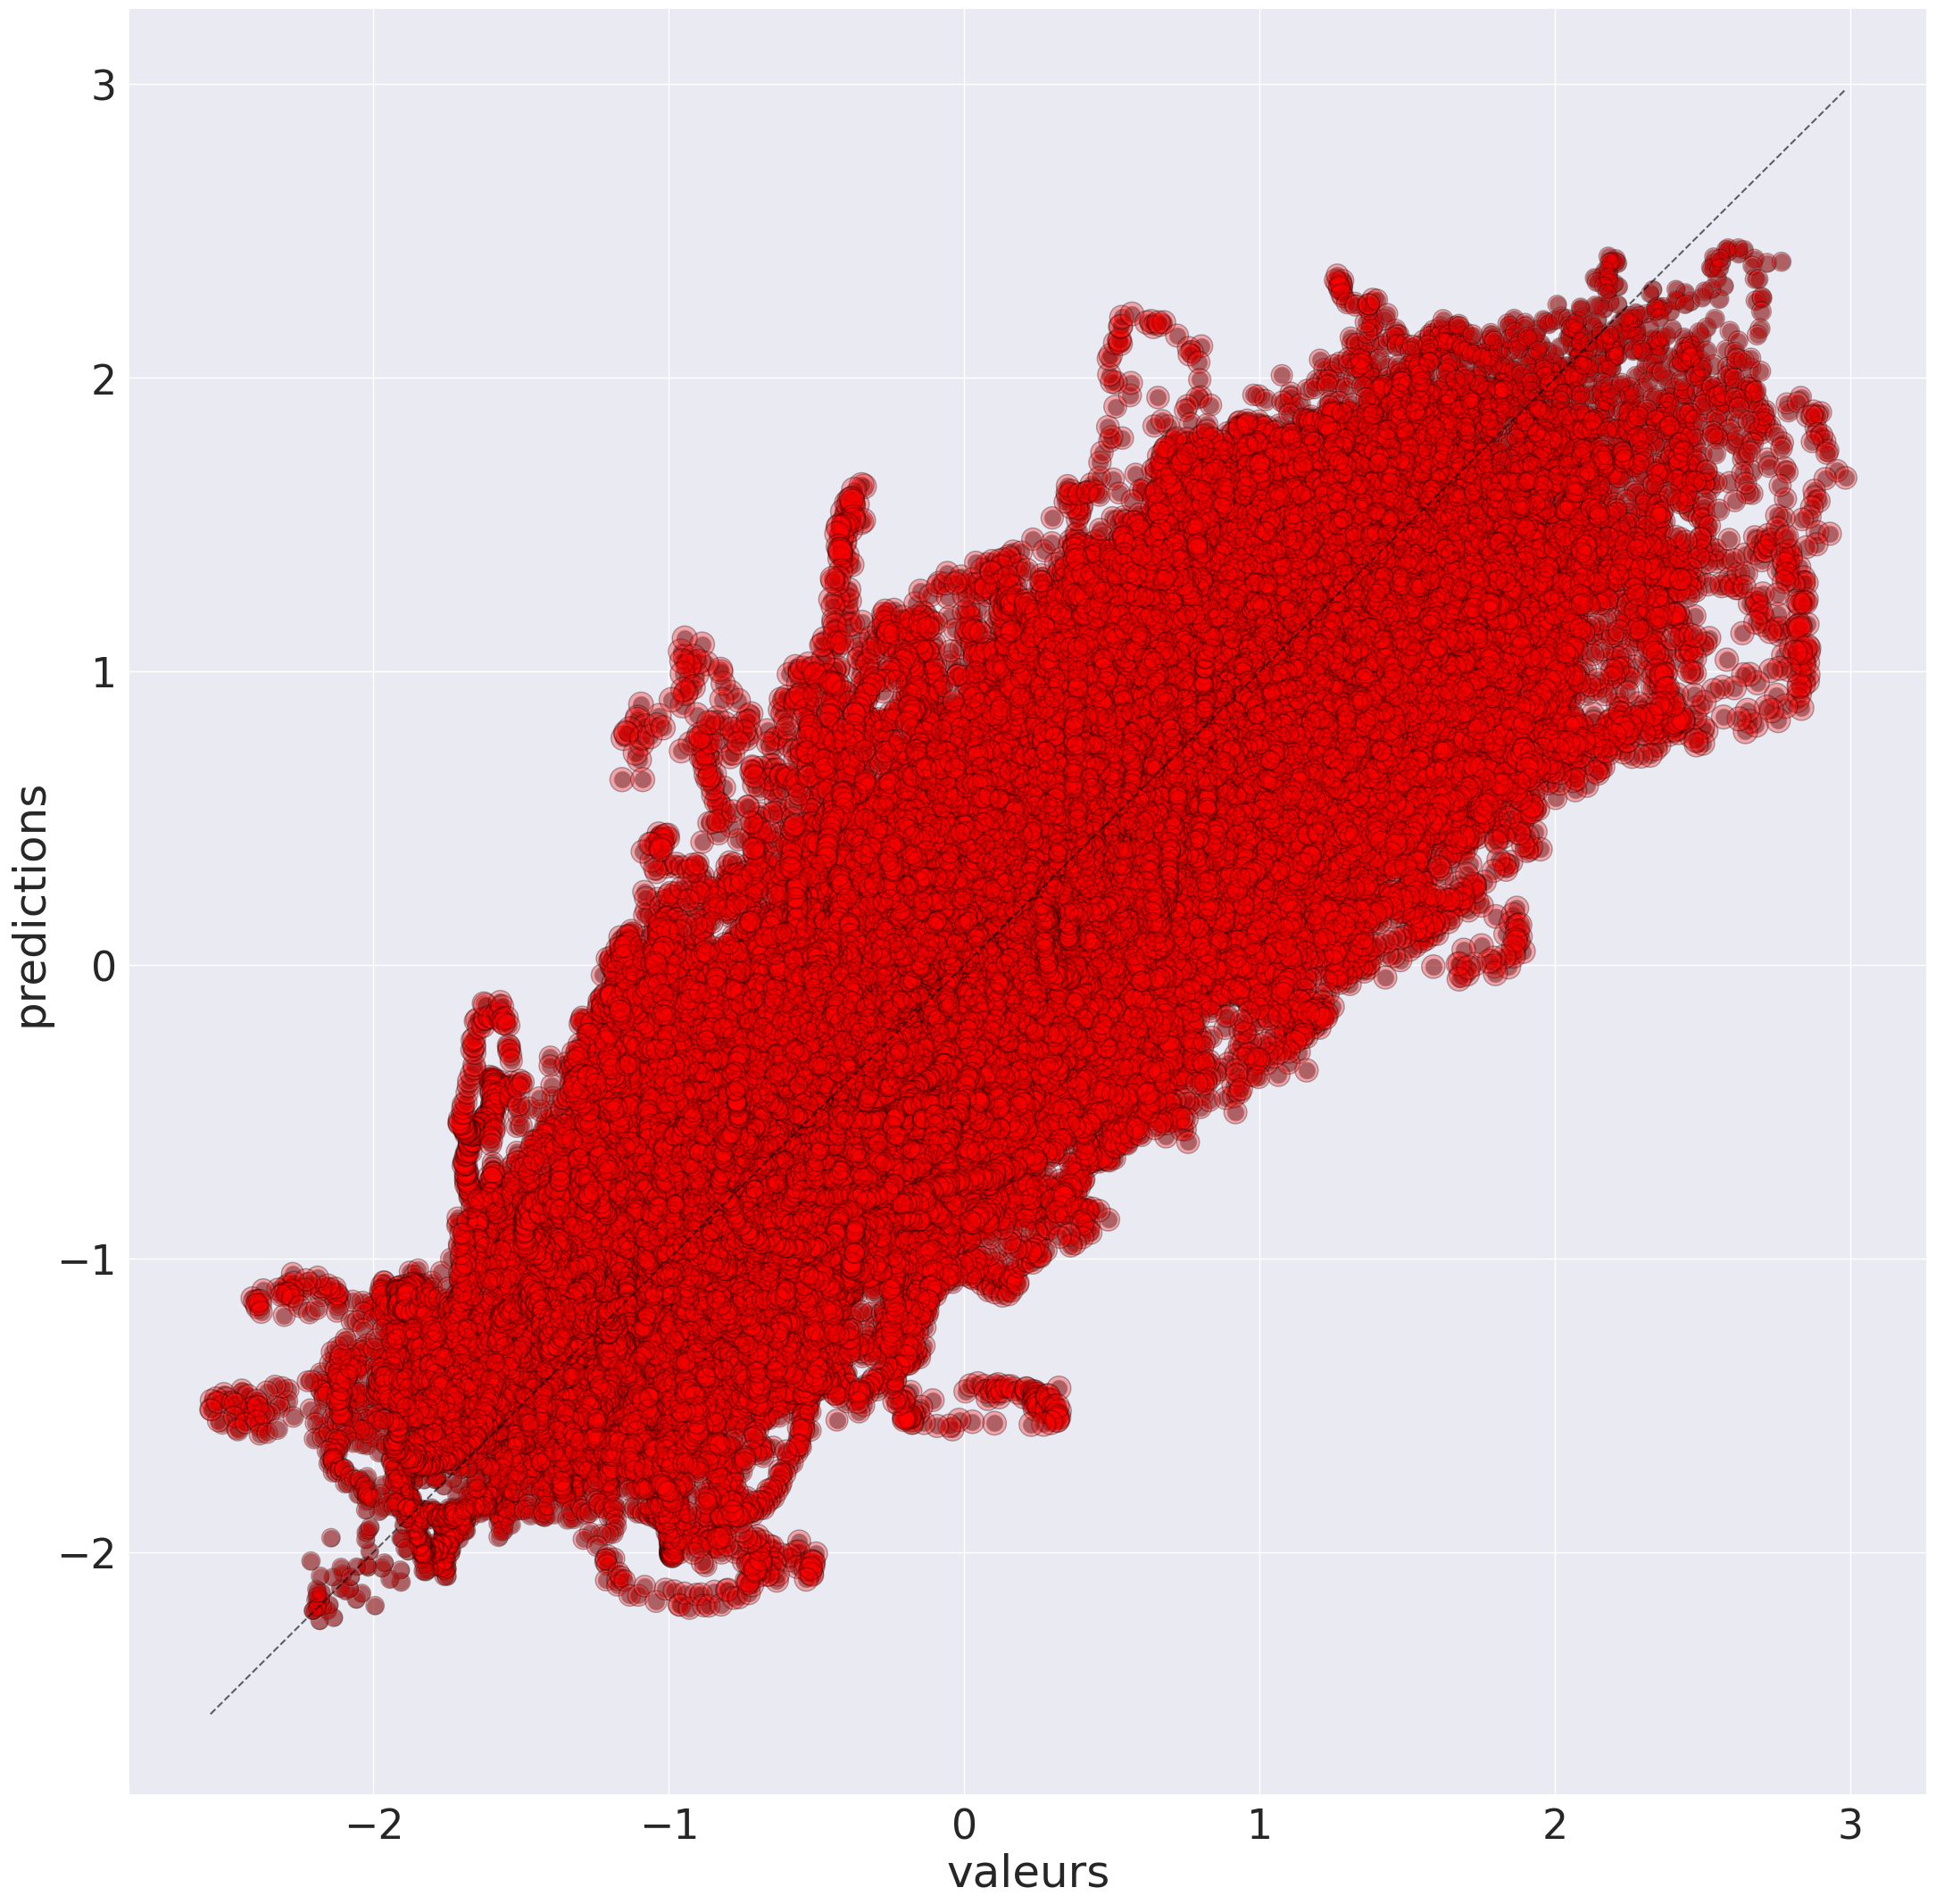

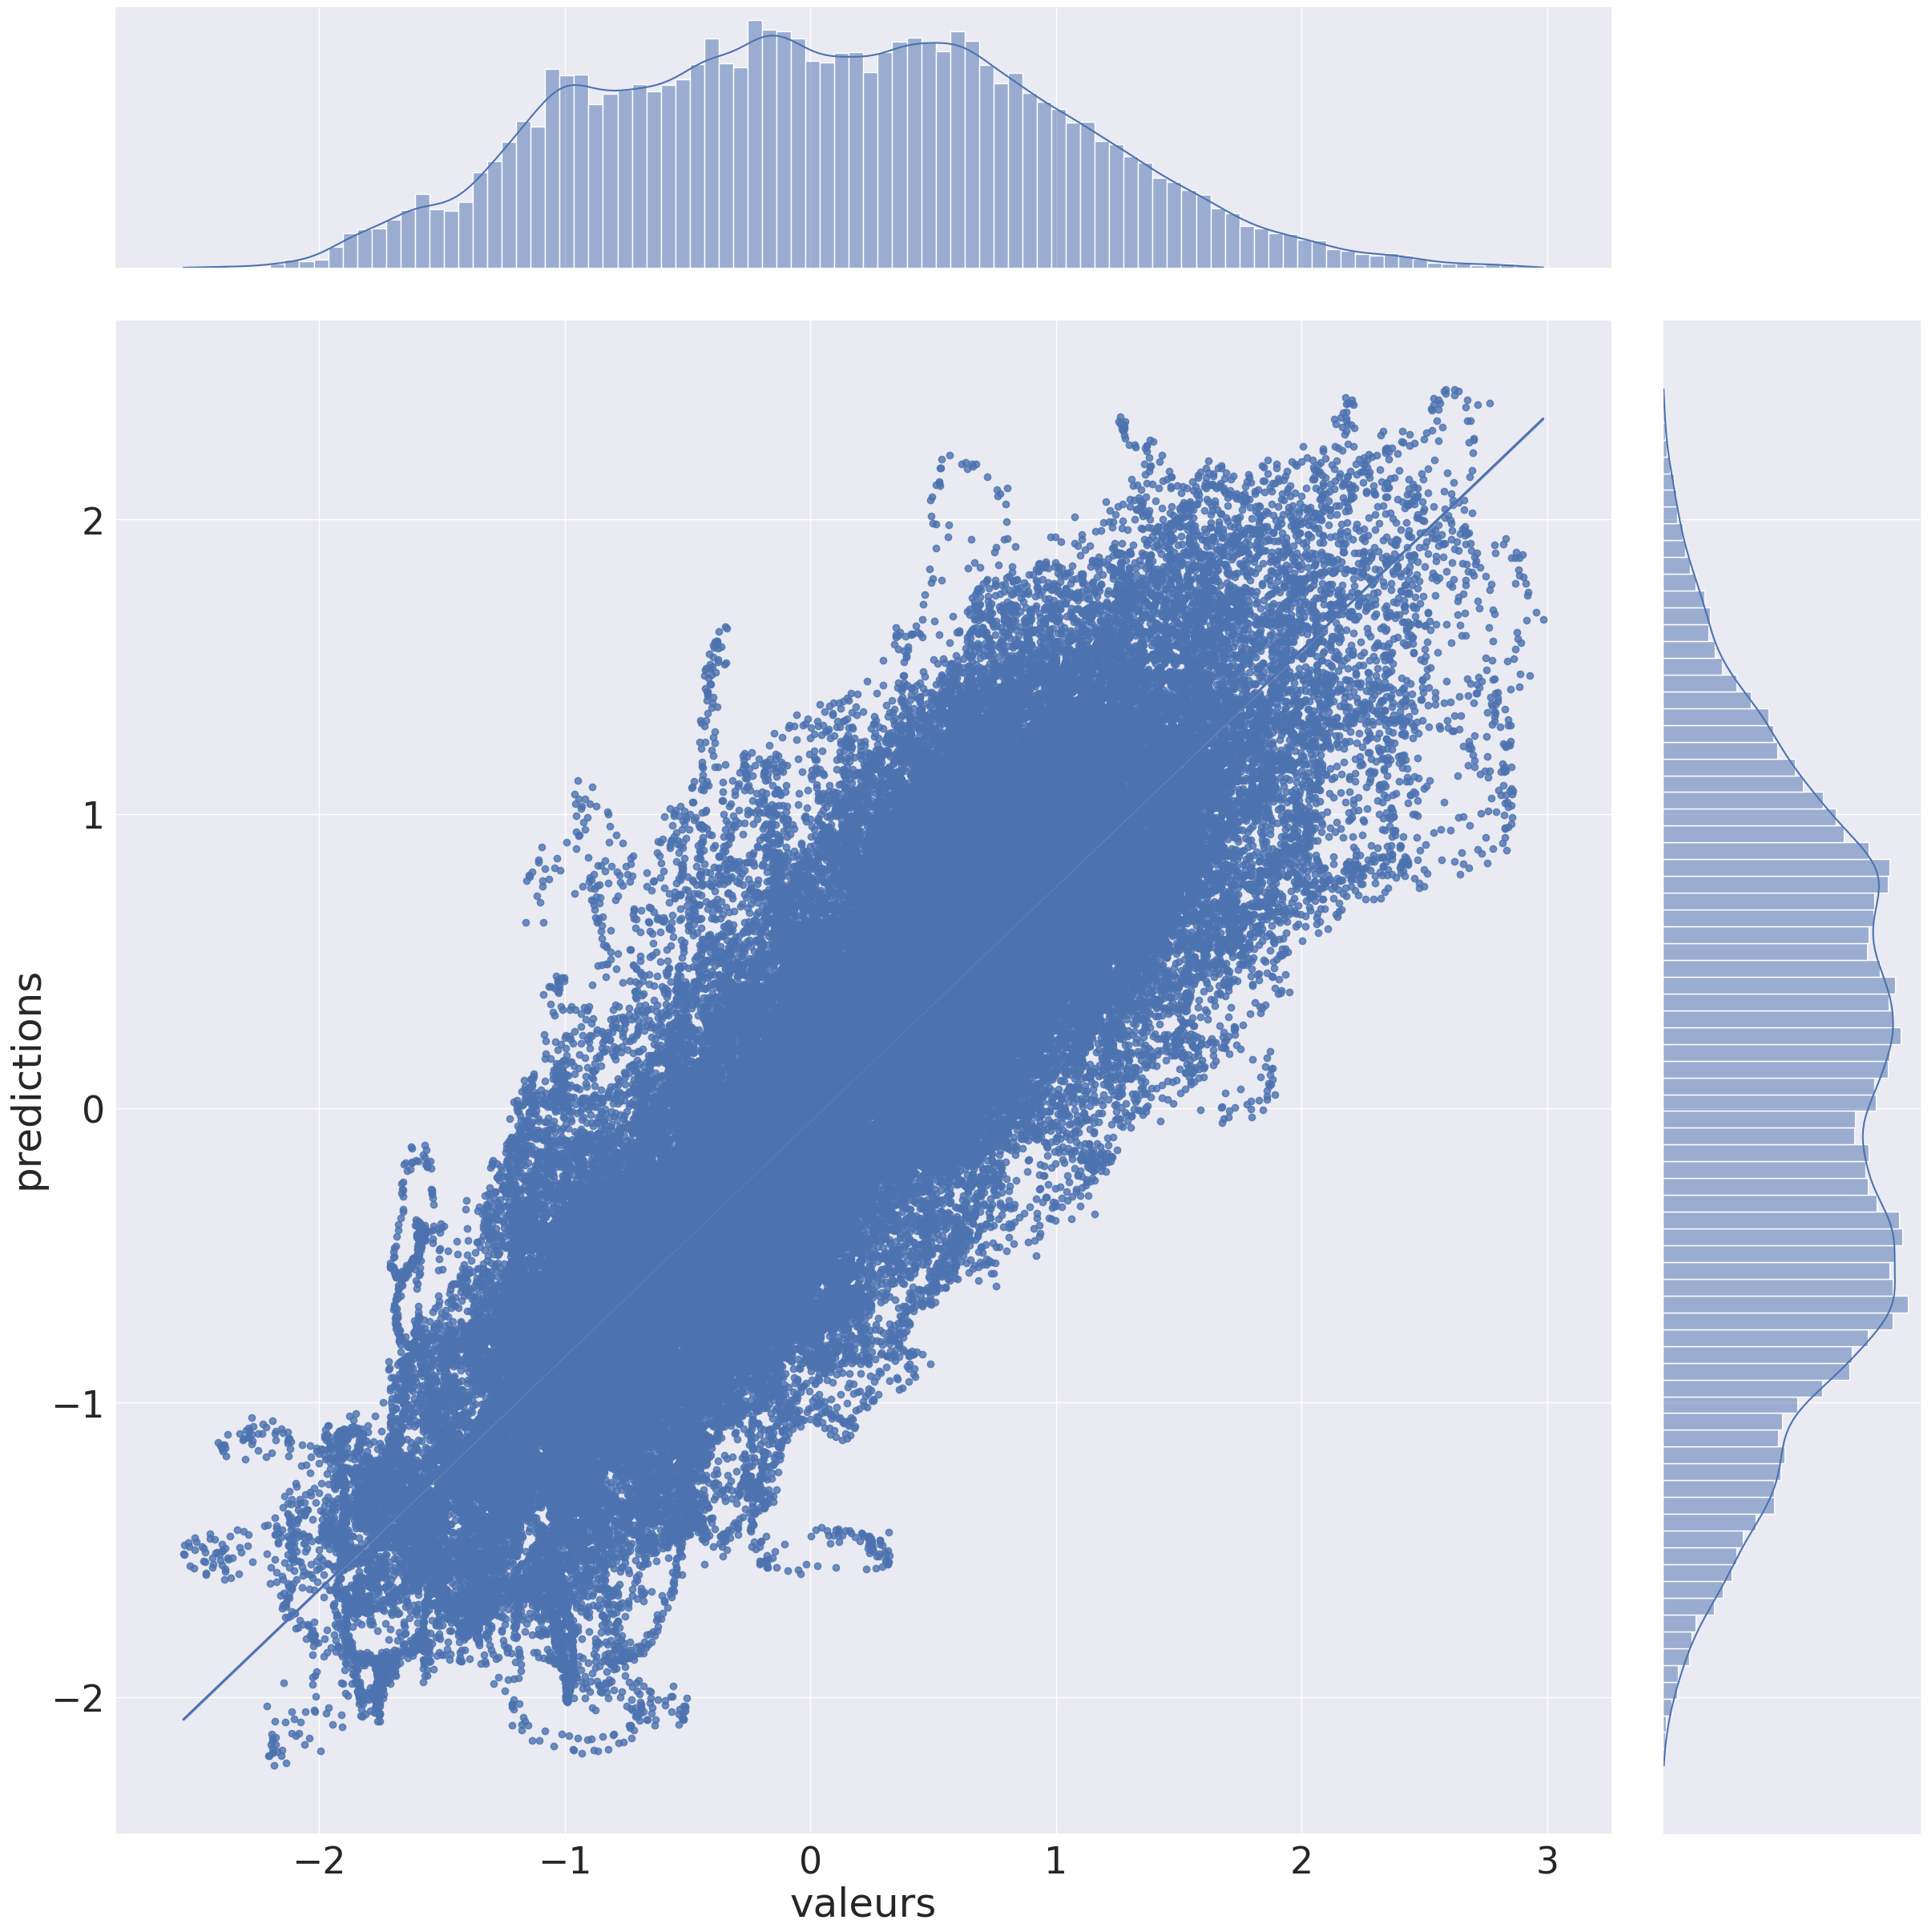

In [45]:
affichageMetricsSansLog(pd.Series(y_test.ravel()), pd.Series(y_pred.ravel()))